In [1]:
import sys
sys.path.append('./library') # age_gender_predictor
sys.path.append('../.env/lib/python2.7/site-packages')
import os 
import pickle
import age_gender_predictor
from collections import defaultdict
import re
from tabulate import tabulate
from datetime import datetime, timedelta
import math
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
import pytz
import json

In [2]:
import sklearn

## Load Regular User

In [3]:
def checkFolderFile(folder):
    return os.listdir(folder)

In [4]:
regular_clean = []
regular_folder = './Regular/'
for regular_file in checkFolderFile(regular_folder):
    regular_clean.append(pd.read_pickle(regular_folder+regular_file))

In [5]:
len(regular_clean)

268

In [6]:
long_regular_clean = []
regular_folder = './Regular_timeline/'
for regular_file in checkFolderFile(regular_folder):
    long_regular_clean.append(pd.read_pickle(regular_folder+regular_file))

In [7]:
len(long_regular_clean)

409

## Load Different Time Period

In [8]:
regular_month15,regular_month12, regular_month9,regular_month6, regular_month3, regular_month2 = [], [], [], [], [], []
regular_varable = [regular_month15,regular_month12, regular_month9,regular_month6, regular_month3, regular_month2]
regular_folder = ['./Regular_15month/','./Regular_12month/','./Regular_9month/','./Regular_6month/','./Regular_3month/','./Regular_2month/']
for i, folder in enumerate(regular_folder):
    for regular_file in checkFolderFile(folder):
        regular_varable[i].append(pd.read_pickle(folder+regular_file))

In [9]:
len(regular_month3)

257

## Load BD

In [10]:
bd_clean = []
bd_folder = './Bipolar/bd_shift2week/'
for bd_file in checkFolderFile(bd_folder):
    bd_clean.append(pd.read_pickle(bd_folder+bd_file))

In [11]:
long_bd_clean = []
bd_folder = './Bipolar_timeline/'
for bd_file in checkFolderFile(bd_folder):
    long_bd_clean.append(pd.read_pickle(bd_folder+bd_file))

## Load Different Time Period

In [12]:
bd_month15, bd_month12, bd_month9, bd_month6, bd_month3, bd_month2 = [], [], [], [], [], []
bd_varable = [bd_month15, bd_month12, bd_month9, bd_month6, bd_month3, bd_month2]
bd_folder = ['./Bipolar_15month/','./Bipolar_12month/','./Bipolar_9month/','./Bipolar_6month/','./Bipolar_3month/','./Bipolar_2month/']
for i, folder in enumerate(bd_folder):
    for bd_file in checkFolderFile(folder):
        bd_varable[i].append(pd.read_pickle(folder+bd_file))
        

In [13]:
len(bd_month2)

133

### Only Before Diagnosed BD Data

In [14]:
# Load bd diagnosed dict
def getDiagnosedDict(file_path):
    res_dict = {}
    with open(file_path) as bd:
        for line in bd.readlines():
            name, diag_time = line.strip().split('\t')
            seg_dia_time = diag_time.split('/')
            year = int(seg_dia_time[0])
            if len(seg_dia_time) == 2:
                res_dict[name] = datetime(year, int(seg_dia_time[1]), 1)
            elif len(seg_dia_time) ==3:
                res_dict[name] = datetime(year, int(seg_dia_time[1]), int(seg_dia_time[2]))
    return res_dict
dia_dict = getDiagnosedDict('./bipolar_list')

In [15]:
bd_month12_, bd_month9_, bd_month6_, bd_month3_, bd_month2_ = [], [], [], [], []
bd_variable = [bd_month12_, bd_month9_, bd_month6_, bd_month3_, bd_month2_]
bd_time = [12,9,6,3,2]
for timeSeries in long_bd_clean:
    username = timeSeries.name[0]
    for i in xrange(len(bd_time)):
        temp_ts = timeSeries[timeSeries.index <= dia_dict[username]]
        if temp_ts.shape[0] > 30 and ((temp_ts.index[-1] - temp_ts.index[0]).days)/25 >= bd_time[i]:
            bd_variable[i].append(temp_ts)

In [16]:
len(bd_month2_)

148

## Load Test Data

In [17]:
def load(folder, col = [ 'name', 'text', 'emotion','emotion_2','ambiguous', 'polarity', 'dt']):
    return [pd.read_csv(folder + file_name, delimiter = '\t', names = col, parse_dates=True) for file_name in os.listdir(folder)]

In [18]:
recent_clean = load('recent_bipolar_test/')

print(len(recent_clean))

25


In [19]:
test_regular = load('normal_900/', col = [ 'name', 'text', 'polarity','emotion','emotion_2','ambiguous', 'dt'])

In [20]:
del test_regular[776]

In [21]:
filtered_test_regular = []
for i, test in enumerate(test_regular):
#     print(i)
    begin_day = test.index[-1] - timedelta(days = 145)
    temp = test[test.index >= begin_day]
    if temp.shape[0] > 100:
        filtered_test_regular.append(temp)
print(len(filtered_test_regular))
# del test_regular

360


In [22]:
import random

In [134]:
test_regular50 = random.sample(filtered_test_regular, 50) 

In [24]:
def segmentPeriod(groups, day = 120, endday = 30):
    return_groups = []
    for timeSeries in groups:
#         period_range = timeSeries.index[-1] - timeSeries.index[0]
        begin = timeSeries.index[-1] - timedelta(days = day)
        end = timeSeries.index[-1] - timedelta(days = endday)
        temp = timeSeries[timeSeries.index >= begin]
        temp = temp[temp.index <= end]
        if temp.shape[0]>0:
            return_groups.append(temp)
    return return_groups

In [153]:
recent_month4x = segmentPeriod(recent_clean, day = 145, endday = 0)
recent_month4 = segmentPeriod(recent_clean, endday = 0)
recent_month3 = segmentPeriod(recent_clean, day = 90, endday = 0)
recent_month2 = segmentPeriod(recent_clean, day = 60, endday = 0)

In [154]:
test_regular_month4x = segmentPeriod(test_regular50, day = 145, endday = 0)
test_regular_month4 = segmentPeriod(test_regular50, endday = 0)
test_regular_month3 = segmentPeriod(test_regular50, day = 90, endday = 0)
test_regular_month2 = segmentPeriod(test_regular50, day = 60, endday = 0)

## Group together

In [27]:
groups = [regular_month2, bd_month2, regular_month3, bd_month3, regular_month6, bd_month6,
          regular_month9, bd_month9, regular_month12, bd_month12, regular_month15, bd_month15,
          recent_month2, recent_month3, recent_month4, recent_clean,
          test_regular_month2, test_regular_month3, test_regular_month4, test_regular_month]
group_names = ["Regular_2", "Bipolar_2", "Regular_3", "Bipolar_3", "Regular_6", "Bipolar_6",
               "Regular_9", "Bipolar_9", "Regular_12", "Bipolar_12", "Regular_15", "Bipolar_15",
               "Recent2", "Recent3", "Recent4", "Recent4.x",
               "Test_Regular2", "Test_Regular3", "Test_Regular4","Test_Regular4.x"]

NameError: name 'recent_month2' is not defined

In [19]:
#Statistics facts of experimental data

headers = ["Group","Users", "Tweets", "Average tweets"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
    tweets_num = sum([timeSeries.shape[0] for timeSeries in group])
    users_num = len(group)
    average_tweets_num = tweets_num / users_num
    contents.append([group_name, users_num, tweets_num, average_tweets_num])
    
print(tabulate(contents, headers=headers))

Group         Users    Tweets    Average tweets
----------  -------  --------  ----------------
Regular_2       260     67485               259
Bipolar_2       133    136837              1028
Regular_3       257     89141               346
Bipolar_3       135    226460              1677
Regular_6       267    136481               511
Bipolar_6       124    353559              2851
Regular_9       289    170380               589
Bipolar_9       117    481392              4114
Regular_12      295    207008               701
Bipolar_12      111    586656              5285
Regular_15      278    213394               767
Bipolar_15      111    692941              6242
Recent2          25     34265              1370
Recent3          25     49248              1969
Recent4          25     65532              2621
Recent4.x        25     80694              3227


## Age Gender

In [28]:
#Age and gender Distribution
def getAgeGender(group):
    features = {"age":[],"gender":[]}
    for timeSeries in group:
        
        features["age"].append(getAge(timeSeries))
        features["gender"].append(getGender(timeSeries))

    return features
def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)

In [21]:
headers = ["Group","Male users", "Female users", "Average age"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
    users_num = float(len(group))
    try:
        users_gender = [getGender(timeSeries) for timeSeries in group]
    except:
        print(i)
        break
    users_age = [getAge(timeSeries) for timeSeries in group]
    male_ratio = len([gender for gender in users_gender if gender < 0]) / users_num
    female_ratio = 1 - male_ratio
    average_age = sum(users_age) / users_num
    contents.append([group_name, male_ratio, female_ratio, average_age])
print(tabulate(contents, headers=headers))

Group         Male users    Female users    Average age
----------  ------------  --------------  -------------
Regular_2       0.503846        0.496154        29.8115
Bipolar_2       0.24812         0.75188         24.8592
Regular_3       0.478599        0.521401        30.1312
Bipolar_3       0.207407        0.792593        24.4102
Regular_6       0.453184        0.546816        30.6582
Bipolar_6       0.233871        0.766129        24.0319
Regular_9       0.477509        0.522491        30.4293
Bipolar_9       0.205128        0.794872        24.3903
Regular_12      0.471186        0.528814        29.7549
Bipolar_12      0.207207        0.792793        24.4096
Regular_15      0.467626        0.532374        30.2141
Bipolar_15      0.189189        0.810811        24.4064
Recent2         0.2             0.8             34.4881
Recent3         0.2             0.8             31.9946
Recent4         0.16            0.84            31.2205
Recent4.x       0.12            0.88            

## Social

In [29]:
def getTweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    if total_tweets == 0: return 0.0
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_tweets / float(total_duration)
    except:
        result = total_tweets / 1.0
    return result

def getLateTweetRate(timeSeries):
    total_late = 0
    for index in timeSeries.index:
        if int(index.hour) <6:
            total_late += 1
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_late / float(total_duration)
    except:
        result = total_late / 1.0
    return result

def getMentionRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries))
    return total_mentions / float(total_tweets)

def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False

def seriesContains(timeSeries):
    match_function = np.vectorize(thirdPronuonDetect)
    return match_function(timeSeries["text"].str.lower().str.split().values)


def getUniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def getFrequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)
 

def getSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": [], "late_tweets_rate": [], "long_tweets_rate": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        social_features["late_tweets_rate"].append(getLateTweetRate(timeSeries))
        try:
            social_features["long_tweets_rate"].append(total_dict[str(timeSeries['name'][0])])
        except:
            print('No found in long_term ' + str(timeSeries['name'][0]))
            social_features["long_tweets_rate"].append(0.0)
    return social_features

def getGBSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        
    return social_features

def getNoLongSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": [], "late_tweets_rate": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        social_features["late_tweets_rate"].append(getLateTweetRate(timeSeries))
        
    return social_features

In [23]:
header = ["tweets_rate", "late_tweets_rate", "mention_rate", "unique_mentions", "frequent_mentions"]
contents = []
for i, group in enumerate(groups):
   
    group_name = group_names[i]
    content = [group_name]
    tweets_rate = np.mean([getTweetRate(timeSeries) for timeSeries in group])
    mention_rate = np.mean([getMentionRate(timeSeries) for timeSeries in group])
    unique_mentions = np.mean([getUniqueMentions(timeSeries) for timeSeries in group])
    frequent_mention = np.mean([getFrequentMentions(timeSeries) for timeSeries in group]) 
    late_tweets_rate = np.mean([getLateTweetRate(timeSeries) for timeSeries in group])
    content += [tweets_rate, late_tweets_rate, mention_rate, unique_mentions, frequent_mention]
    contents.append(content)


print("\n======Mean Distribution======\n")

print(tabulate(contents, headers=header,))


======Mean Distribution======

              tweets_rate    late_tweets_rate    mention_rate    unique_mentions    frequent_mentions
----------  -------------  ------------------  --------------  -----------------  -------------------
Regular_2         4.49298            0.414508        0.431381            53.6769              11.5
Bipolar_2        17.956              4.04942         0.396966           117.489               36.3308
Regular_3         3.99729            0.338119        0.421551            71.3307              15.7004
Bipolar_3        17.4618             3.85854         0.402067           169.622               54.1556
Regular_6         2.85013            0.310132        0.427669            92.4981              20.8989
Bipolar_6        15.2578             3.56412         0.409098           267.5                 84.9758
Regular_9         2.17571            0.256841        0.421164           103.239               23.8062
Bipolar_9        14.7925             3.75256         

In [24]:
# header = ["tweets_rate", "late_tweets_rate", "mention_rate", "unique_mentions", "frequent_mentions"]
# contents = []
# for i, timeSeries in enumerate(regular_clean):
# #     content = [i]
#     content = [str(timeSeries['name'][0])]
#     tweets_rate = getTweetRate(timeSeries)
#     mention_rate = getMentionRate(timeSeries)
#     unique_mentions = getUniqueMentions(timeSeries)
#     frequent_mention = getFrequentMentions(timeSeries)
#     late_tweets_rate = getLateTweetRate(timeSeries)
#     content += [tweets_rate, late_tweets_rate, mention_rate, unique_mentions, frequent_mention]
#     contents.append(content)
# print("\n======Mean Distribution======\n")
# print(tabulate(contents, headers=header,))

## Polarity Feature

In [30]:
def getFlipsCount(timeSeries, upperbound=120, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )

def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def getFlipsDuration(timeSeries, flips):
    filtered_timeSeries = timeSeries['dt'][flips].index.values
    dt = np.zeros(filtered_timeSeries.shape[0],dtype=float)
    dt[:-1] = (filtered_timeSeries[1:] - filtered_timeSeries[:-1]).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return dt

def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / float(total_tweets)

def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / float(total_tweets)

def getPolarity(group):
    polarity = {"flips":[],"negative_combos":[],"positive_combos":[], "positive_ratio":[], "negative_ratio":[]}
    for timeSeries in group:
        try:
            tweets_length = float(timeSeries.shape[0])
        except:
            print 'error'
            print timeSeries
            break
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos_ratio = getCombosCount(timeSeries,matcher=-1) / tweets_length
        positive_combos_ratio = getCombosCount(timeSeries,matcher=1) / tweets_length
        positive_ratio = getPositiveRatio(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        
        polarity["flips"].append(flips_ratio)
        polarity["negative_combos"].append(negative_combos_ratio)
        polarity["positive_combos"].append(positive_combos_ratio)
        polarity["positive_ratio"].append(positive_ratio)
        polarity["negative_ratio"].append(negative_ratio)
        
    return polarity

def comboTracker(timeSeries, attribute= "polarity", lowerbound = 120):
    array = timeSeries[attribute]
#     the polarity of starter
    starter = array[0]
    combo = 1
    result = []
    i = 0 
#     begin from second one in the array
    for cursor in array[1:]:
        i += 1
        if starter == cursor and timeSeries["dt"][i-1] < lowerbound:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

In [26]:
headers = ["Group","Positive Ratio","Negative Ratio", "Flip Ratio", "Positive Combos", "Negative Combos"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
   
    positive_ratio_mean = np.mean([getPositiveRatio(timeSeries) for timeSeries in group])
    negative_ratio_mean = np.mean([getNegativeRatio(timeSeries) for timeSeries in group])
    flips_ratio_mean = np.mean([getFlipsCount(timeSeries) / float(len(timeSeries)) for timeSeries in group])
    negative_combos_ratio = np.mean([getCombosCount(timeSeries,matcher=-1) / float(len(timeSeries)) for timeSeries in group])
    positive_combos_ratio = np.mean([getCombosCount(timeSeries,matcher=1) / float(len(timeSeries)) for timeSeries in group])
    
    contents.append([group_name, positive_ratio_mean, negative_ratio_mean, flips_ratio_mean, positive_combos_ratio, negative_combos_ratio])
print("\n=========\n")
print(tabulate(contents, headers=headers))



Group         Positive Ratio    Negative Ratio    Flip Ratio    Positive Combos    Negative Combos
----------  ----------------  ----------------  ------------  -----------------  -----------------
Regular_2          0.223811           0.108312    0.00432236         0.0332145          0.00439527
Bipolar_2          0.0982161          0.172691    0.00578583         0.00643929         0.0186712
Regular_3          0.214817           0.109222    0.00470779         0.030426           0.0031437
Bipolar_3          0.097095           0.173152    0.00561589         0.00620796         0.0191976
Regular_6          0.223818           0.112794    0.00440139         0.0323001          0.00564947
Bipolar_6          0.100064           0.167476    0.00546895         0.00615428         0.0177763
Regular_9          0.225617           0.115473    0.00429804         0.0266098          0.00338021
Bipolar_9          0.100268           0.16423     0.0052977          0.00738731         0.0164242
Regular_12   

In [27]:
headers = ["Group","Positive Ratio Mean","Positive Ratio STD", "Negative Ratio Mean", "Negative Ratio STD"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
   
    positive_ratios = [getPositiveRatio(timeSeries) for timeSeries in group]
    negative_ratios = [getNegativeRatio(timeSeries) for timeSeries in group]
    positive_ratio_mean = np.mean(positive_ratios)
    negative_ratio_mean = np.mean(negative_ratios)
    positive_ratio_std = np.std(positive_ratios)
    negative_ratio_std = np.std(negative_ratios)

    contents.append([group_name, positive_ratio_mean, positive_ratio_std, negative_ratio_mean, negative_ratio_std])
print("\n=========\n")
print(tabulate(contents, headers=headers))



Group         Positive Ratio Mean    Positive Ratio STD    Negative Ratio Mean    Negative Ratio STD
----------  ---------------------  --------------------  ---------------------  --------------------
Regular_2               0.223811              0.158477                0.108312             0.0823516
Bipolar_2               0.0982161             0.0590432               0.172691             0.0754925
Regular_3               0.214817              0.145268                0.109222             0.0795563
Bipolar_3               0.097095              0.0570975               0.173152             0.0747214
Regular_6               0.223818              0.144994                0.112794             0.0837599
Bipolar_6               0.100064              0.0644627               0.167476             0.0670088
Regular_9               0.225617              0.142528                0.115473             0.0817134
Bipolar_9               0.100268              0.0555564               0.16423            

## Emotion

In [31]:
def getUsersEmotions(timeSeries):
    non_ambiguous = np.invert(timeSeries["ambiguous"].values)
    
    filtered_emotions = timeSeries["emotion"][non_ambiguous].values
    emotions_count = {"joy":0,"sadness": 0,"fear":0,\
                "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}
    if float(filtered_emotions.shape[0]) == 0:
        divider = 1.0
    else:
        divider = float(filtered_emotions.shape[0])
    for emotion in emotions_count:
        emotions_count[emotion] = np.sum(filtered_emotions == emotion) / divider
    return emotions_count

def getGroupEmotions(group):
    emotions_counts = {"joy":[],"sadness": [],"fear":[],\
                "anticipation": [], "anger":[], "trust": [], "disgust": [] ,"surprise" : []}
    for timeSeries in group:
        emotions_count = getUsersEmotions(timeSeries)
        for emotion, count in emotions_count.items():
            emotions_counts[emotion].append(count)
    return emotions_counts



In [29]:
emotions = ["joy","sadness","fear", "anticipation", "anger", "trust", "disgust" ,"surprise"]

headers = ["Group"] + emotions
contents = []
for i, group in enumerate(groups):
   
    group_name = group_names[i]
    content = [group_name]
    emotions_counts = getGroupEmotions(group)
    for emotion in emotions:
        emotion_ratio = "{}%".format(round(np.mean(emotions_counts[emotion])*100, 2))
        
        content.append(emotion_ratio)
    contents.append(content)
    
print("\n======Eight Emotional Features======\n")

print("\n======Distribution======\n")

print(tabulate(contents, headers=headers,))



======Eight Emotional Features======


======Distribution======

Group       joy     sadness    fear    anticipation    anger    trust    disgust    surprise
----------  ------  ---------  ------  --------------  -------  -------  ---------  ----------
Regular_2   16.17%  26.27%     6.67%   13.84%          6.98%    15.14%   11.69%     3.25%
Bipolar_2   13.73%  28.14%     4.09%   14.27%          13.26%   5.62%    16.5%      4.39%
Regular_3   15.99%  26.33%     6.78%   14.04%          7.08%    14.58%   11.92%     3.29%
Bipolar_3   13.69%  28.46%     4.21%   14.02%          13.15%   5.39%    16.67%     4.42%
Regular_6   16.48%  26.13%     6.88%   13.61%          7.03%    14.9%    11.8%      3.18%
Bipolar_6   13.81%  28.0%      4.07%   14.31%          13.21%   5.41%    16.7%      4.51%
Regular_9   16.87%  25.81%     6.62%   13.84%          7.14%    14.57%   11.96%     3.19%
Bipolar_9   14.15%  27.34%     4.19%   14.38%          13.05%   5.65%    16.65%     4.59%
Regular_12  17.09%  25.97%

## Long Term Feature

In [32]:
# 8 weeks sliding windows, move 1 week per time
def slideWindows(timeline, start):
    
    limit = start + timedelta(weeks=8)
    
    status = False
    if timeline.index[-1] < limit: status = True
    
    new_start = start + timedelta(weeks=1)
    
    return timeline[timeline.index < limit], new_start, timeline[timeline.index > new_start],status
    
        
def getTimeSeries(timeline):
    timeSeries_list = []
    start = timeline.index[0]
    
    while True:
        timeSeries, start, timeline, status = slideWindows(timeline, start)
        timeSeries_list.append(timeSeries)
        if status: break
            
    return timeSeries_list

In [37]:
bd_dict = {}
regular_dict = {}
for i, bd_timeline in enumerate(long_bd_clean):
    try:
        tweets_rate_array = np.asarray([getTweetRate(timeSeries) for timeSeries in getTimeSeries(bd_timeline)])
    except:
        tweets_rate_array = np.asarray([0.0, 0.0])
    bd_dict[str(bd_timeline['name'][0])] = np.ptp(tweets_rate_array)
    
for i, regular_timeline in enumerate(long_regular_clean):
    try:
        tweets_rate_array = np.asarray([getTweetRate(timeSeries) for timeSeries in getTimeSeries(regular_timeline)])
    except:
        tweets_rate_array = np.asarray([0.0, 0.0])
    regular_dict[str(regular_timeline['name'][0])] = np.ptp(tweets_rate_array)

total_dict = {}
total_dict.update(bd_dict)
total_dict.update(regular_dict)
del bd_dict
del regular_dict

In [38]:
len(total_dict)

574

In [39]:
recent_dict = {}
for i, timeline in enumerate(recent_clean):
    try:
        tweets_rate_array = np.asarray([getTweetRate(timeSeries) for timeSeries in getTimeSeries(regular_timeline)])
    except:
        tweets_rate_array = np.asarray([0.0, 0.0])
    recent_dict[str(timeline['name'][0])] = np.ptp(tweets_rate_array)
    
print(len(recent_dict))
total_dict.update(recent_dict)
print((len(total_dict)))
del recent_dict

25
599


In [40]:
tresult_dict = {}
for i, timeline in enumerate(test_regular):
    try:
        tweets_rate_array = np.asarray([getTweetRate(timeSeries) for timeSeries in getTimeSeries(regular_timeline)])
    except:
        tweets_rate_array = np.asarray([0.0, 0.0])
    tresult_dict[str(timeline['name'][0])] = np.ptp(tweets_rate_array)
print(len(tresult_dict))
total_dict.update(tresult_dict)
print((len(total_dict)))
del tresult_dict

931
1530


### LIWC

In [33]:
#Functions for LIWC and POL features extraction:
def loads_LIWC():
    f = open("LIWC/categories.json", 'r')
    categories = json.load(f)
    f = open("LIWC/words.json", 'r')
    words = json.load(f)
    patterns_categories = {}
    for word, category in words.items():
        if word[-1] == '*':
            current_dict = patterns_categories
            for char in word:
                if char == '*':
                    #current_dict = category
                    pre_dict[word[-2]] = category
                    break
                
                elif char not in current_dict:
                    current_dict[char] = {}
                pre_dict = current_dict
                current_dict = current_dict[char]
                
    return categories, words, patterns_categories

LIWC_categories, LIWC_words, LIWC_patterns_categories = loads_LIWC()

def getLIWC_user(timeSeries):
    LIWC_counts = {}
    features = np.zeros(len(LIWC_categories),dtype=int)
    
    texts= timeSeries["text"].values
    for text in texts:
        words = text.strip().split()
        for word in words:
            category_indices = LIWC_words.get(word,[])
            if category_indices == []:
                current_dict = LIWC_patterns_categories
                for char in word[:-1]:
                    current_dict = current_dict.get(char,[])
                    if isinstance(current_dict,list):
                        category_indices = current_dict                            
                        break

            for category_index in category_indices:
                category_name = LIWC_categories[category_index]
                LIWC_counts[category_name] = LIWC_counts.get(category_name,0) + 1

    for category_name in LIWC_counts:
        LIWC_counts[category_name] /= timeSeries.shape[0]
    
    return LIWC_counts

def getLIWC_group(group):
    LIWC_counts = {}
    users_num = len(group)
    for category in LIWC_categories.values():
        LIWC_counts[category] = []
    for timeSeries in group:
        user_LIWC_count = getLIWC_user(timeSeries)
      
        for category in LIWC_categories.values():
            LIWC_counts[category].append(user_LIWC_count.get(category,0))
            
    return LIWC_counts

## Group Class

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib import rcParams
from random import randint
from operator import itemgetter 
import time
rcParams['figure.figsize'] = 12, 8

/home/eric/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
# function to delete url
def del_url(line):
    return re.sub(r'(\S*(\.com).*)|(https?:\/\/.*)', "", line)

In [36]:
#Wrap group to be object
class Group(object):
    def __init__(self, group_name, group_data_list):
        self.name = group_name
        self.timeSerieses_list = group_data_list
        
    def getName(self):
        return self.name
    
    def getSize(self):
        return len(self.timeSerieses_list)
    
    def getTexts(self, tail_k = "all"):
        if tail_k == "all":
            return ["\n".join(map(del_url, timeSeries["text"].values)) for timeSeries in self.timeSerieses_list]
        else:
            return ["\n".join(map(del_url, timeSeries["text"].tail(tail_k).values)) for timeSeries in self.timeSerieses_list]
    
    def getGroup(self, tail_k="all"):
        if tail_k =="all":
#             return [timeSeries for timeSeries in self.timeSerieses_list if str(timeSeries['name'][0]) in total_dict]
            
            return self.timeSerieses_list
        else:
            return [timeSeries.tail(tail_k) for timeSeries in self.group]

In [38]:
# bipolar_group = Group("Bipolar", bd_clean)
# regular_group = Group("Regular", regular_clean)

# long_bipolar_group = Group("Long_Bipolar", long_bd_clean)
# long_regular_group = Group("Long_Regular", long_regular_clean)

In [41]:
bd2_group = Group("Bd_2", bd_month2_)
bd3_group = Group("Bd_3", bd_month3_)
bd6_group = Group("Bd_6", bd_month6_)
bd9_group = Group("Bd_9", bd_month9_)
bd12_group = Group("Bd_12", bd_month12_)


In [42]:
bipolar2_group = Group("Bipolar_2", bd_month2)
regular2_group = Group("Regular_2", regular_month2)

bipolar3_group = Group("Bipolar_3", bd_month3)
regular3_group = Group("Regular_3", regular_month3)

bipolar6_group = Group("Bipolar_6", bd_month6)
regular6_group = Group("Regular_6", regular_month6)

bipolar9_group = Group("Bipolar_9", bd_month9)
regular9_group = Group("Regular_9", regular_month9)

bipolar12_group = Group("Bipolar_12", bd_month12)
regular12_group = Group("Regular_12", regular_month12)

bipolar15_group = Group("Bipolar_15", bd_month15)
regular15_group = Group("Regular_15", regular_month15)

In [43]:
del bd_month2, regular_month2, bd_month3, regular_month3, bd_month6, regular_month6, bd_month9, regular_month9, bd_month12, regular_month12, bd_month15, regular_month15

In [155]:
recent_group5 = Group("Recent_5", recent_month4x)
recent_group4 = Group("Recent_4", recent_month4)
recent_group3 = Group("Recent_3", recent_month3)
recent_group2 = Group("Recent_2", recent_month2)

In [156]:
test_regular_group5 = Group("TRegular_5", test_regular_month4x)
test_regular_group4 = Group("TRegular_4", test_regular_month4)
test_regular_group3 = Group("TRegular_3", test_regular_month3)
test_regular_group2 = Group("TRegular_2", test_regular_month2)

In [46]:
def getCategories(group):
    '''
    Input  : the group (Class) of user
    Output : Dictionary of feature name and feature's group pairs

    e.g.
    'tweets_rate': 'GBSocial'
    'unique_mentions': 'GBSocial'
    '''
    name2category = {}
    names = ["Emotions", "Polarity", "AgeGender", "LIWC",
             "LongSocial", "lateSocial", "GBSocial"]
    methods = [getGroupEmotions, getPolarity, getAgeGender, getLIWC_group, 
               getSocialFeature_group,  getNoLongSocialFeature_group, getGBSocialFeature_group]
    for i, method in enumerate(methods):
        if method == getLIWC_group:
            feature = {"LIWC_"+key: value for key, value in method(group.getGroup()).items()}
        else:
            feature = method(group.getGroup())
        for key in feature:
            name2category[key] = names[i]
    return name2category

def getAllFeature(group, tail_k = "all"):
    feature_set = {}
    methods = [getGroupEmotions, getPolarity, getAgeGender, getLIWC_group, 
               getSocialFeature_group,  getNoLongSocialFeature_group, getGBSocialFeature_group]
    for method in methods:
        if method == getLIWC_group:
            LIWC_feature_set = {"LIWC_"+key: value for key, value in method(group.getGroup(tail_k)).items()}
            feature_set.update(LIWC_feature_set)
        else:
            feature_set.update(method(group.getGroup()))
    return feature_set

## Classifier

### The TF-IDF models are trained in the following class

In [48]:
#A TF-IDF class to implement TF-IDF extraction and model training.
class TextFeatureGroups(object):
    def __init__(self, base, groups, model = "Tf-iDF"):
        self.base = base
        self.groups = groups
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
       
        base_texts = base.getTexts()
        self.text_models = []
        self.classifiers = []
        pairs_num = len(groups)/2
#         for i in range(pairs_num):
#             group_texts = group.getTexts()
#             total_texts = base_texts  + group_texts
#             text_model = TfidfVectorizer(stop_words="english", ngram_range = (1,2))
#             text_model.fit(total_texts)    
#             X = text_model.fit_transform(total_texts)  
#             Y = np.array([0] * base.getSize() + [1]*group.getSize(), dtype=int)
#             classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
#             classifier.fit(X,Y)
#             self.classifiers.append(classifier)
#             self.text_models.append(text_model)
        for group in groups:
            group_texts = group.getTexts()
            total_texts = base_texts  + group_texts
            text_model = TfidfVectorizer(stop_words="english", ngram_range = (1,2))
            text_model.fit(total_texts)    
            X = text_model.fit_transform(total_texts)  
            Y = np.array([0] * base.getSize() + [1]*group.getSize(), dtype=int)
            classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
            classifier.fit(X,Y)
            self.classifiers.append(classifier)
            self.text_models.append(text_model)
    
    def getTopFeatures(self, name, k=50):
        index = self.name_to_index[name]
        text_model = self.text_models[index]
        classifier = self.classifiers[index]
        feature_indicies = np.argsort(classifier.feature_importances_)
        vector2word = text_model.get_feature_names()
        top_words = []
        for i in range(k):
            vector = feature_indicies[-i-1]
            word = vector2word[vector]
            top_words.append(word)
        return top_words

    def getGroup(self,name):
        index = self.name_to_index[name]
        return self.groups[index]
            
    def classify(self,name, group):
        index = self.name_to_index[name]
        classifier = self.classifiers[index]
        text_model = self.text_models[index]
        X = text_model.transform(group.getTexts())
        return classifier.predict(X) 
    
    def getPrecision(self,name, tail_k="all", classifier = "default", n_fold=10):
        index = self.name_to_index[name]
        group = self.groups[index]
        if classifier == "default":
            classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        #classifier = SVC(probability=True)
        #X = self.text_models[index].transform(self.base.getTexts(tail_k)+group.getTexts(tail_k))
        text_model = self.text_models[index]
        raw_X = self.base.group + group.group
        Y =  np.array([0] * self.base.getSize() + [1] * group.getSize())
        precisions = []
        
        complete_X = text_model.transform(self.base.getTexts()+group.getTexts())
        tailed_X =  text_model.transform(self.base.getTexts(tail_k)+group.getTexts(tail_k))
        
        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            
            X_train, X_test = complete_X[train_index], tailed_X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            classifier.fit(X_train, Y_train)
            score = classifier.score(X_test,Y_test)
            precisions.append(score)

        return np.mean(precisions)
        
    
    def getLabelsScores(self, name, classifier, n_fold, consider_time = "short"):
        index = self.name_to_index[name]
        group = self.groups[index]

        SCORES = np.array([])
        LABELS = np.array([])
        
#         Based may change by situation
        if consider_time == "short":
            X = self.text_models[index].transform(self.base.getTexts()+group.getTexts())
            Y =  np.array([0] * self.base.getSize() + [1] * group.getSize())  
        elif consider_time == "long":
            X = self.text_models[index].transform(self.groups[0].getTexts()+group.getTexts())
            Y =  np.array([0] * self.groups[0].getSize() + [1] * group.getSize())  
        else:
            X = self.text_models[index].transform(self.groups[self.name_to_index["Regular_" + str(consider_time)]].getTexts()+group.getTexts())
            Y =  np.array([0] * self.groups[self.name_to_index["Regular_" + str(consider_time)]].getSize() + [1] * group.getSize())  

        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536))

        for train_index, test_index in sss:
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))

        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test)
        
    def renderPrecisionRecall(self, colors=['r','g','b',"y","c","m","#f4b642","#777777"], n_fold = 10):
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.title.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')

        for g, group in enumerate(self.groups):
            SCORES, LABELS,(X_train, X_test,Y_train, Y_test) = self.getLabelsScores(group.getName(), classifier ,n_fold)

            precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS, SCORES)

            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test

            print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,group.getName()))
            print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,group.getName()))
            plt.plot(recall, precision, label=group.getName() , color=colors[g],linewidth=3)

        plt.legend(loc="lower right")
        plt.show()


# Build the TF-IDF class
tfidf_groups = TextFeatureGroups(regular2_group, [regular2_group, regular3_group, regular6_group, regular9_group, regular12_group, regular15_group, 
                                                  bipolar2_group, bipolar3_group, bipolar6_group, bipolar9_group, bipolar12_group, bipolar15_group])

# Extract Top 10 keywords by TF-IDF model for Bipolar and BPD
print(tfidf_groups.getTopFeatures("Bipolar_2"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_3"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_6"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_9"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_12"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_15"))

[u'nasty', u'fucked', u'meds', u'lost', u'kill', u'death', u'disorder', u'diagnosed bipolar', u'drugs', u'love', u'mental health', u'like', u'empty_tweets', u'haven', u'hate hate', u'thing', u'changed', u'eventually', u'oh', u'feel', u'jesus', u'merry', u'asshole', u'stop', u'guess', u'best friend', u'suicide', u'breathe', u'instead', u'ice', u'mental illness', u'ily', u'pills', u'oh god', u'likes', u'upset', u'sadness', u'fake', u'just waiting', u'story', u'bad', u'duh', u'good', u'gay', u'people like', u'wish', u'gone', u'merry christmas', u'facebook', u'slut']



[u'dying', u'body', u'cousin', u'nose', u'sent', u'die', u'does', u'best friends', u'worse', u'dick', u'sound', u'people don', u'eyes', u'swear', u'rip', u'hello', u'person', u'wonder', u'slept', u'mean', u'chest', u'don wanna', u'people tell', u'young', u'depressed', u'written', u'stole', u'huh', u'likes', u'therapy', u'wants', u'kick', u'reason', u'like fuck', u'thoughts', u'bipolar', u'story', u'relate', u'lately', u'one

In [49]:
tfidf_groups_ = TextFeatureGroups(regular2_group, [regular2_group, regular3_group, regular6_group, regular9_group, regular12_group, 
                                                  bd2_group, bd3_group, bd6_group, bd9_group, bd12_group])


In [50]:
print(tfidf_groups_.getTopFeatures("Bd_2"))
print("\n\n")
print(tfidf_groups_.getTopFeatures("Bd_3"))
print("\n\n")
print(tfidf_groups_.getTopFeatures("Bd_6"))
print("\n\n")
print(tfidf_groups_.getTopFeatures("Bd_9"))
print("\n\n")
print(tfidf_groups_.getTopFeatures("Bd_12"))

[u'mood', u'oh god', u'shows', u'childhood', u'hands', u'afraid', u'don like', u'live', u'tried', u'legs', u'dear', u'look like', u'took', u'kiss', u'merry', u'don need', u'tears', u'normal', u'box', u'feel better', u'second', u'freak', u'just don', u'pain', u'idiot', u'shopping', u'books', u'bother', u'brain', u'knows', u'love just', u'coffee', u'addicted', u'pretend', u'oh shit', u'wish', u'make feel', u'wall', u'slut', u'fly', u'boys', u'woke', u'babe', u'funny', u'punch', u'biggest', u'loud', u'empty_tweets', u'glasses', u'boyfriend']



[u'bringing', u'best friend', u'tree', u'breaking', u'18', u'scream', u'wake', u'talks', u'judge', u'lord', u'boobs', u'knew', u'air', u'decide', u'idea', u'girls', u'ugly', u'loves', u'normal', u'smells like', u'suffer', u'safe', u'nose', u'strong', u'lovely', u'people say', u'slowly', u'secretly', u'depressed', u'makes happy', u'apparently', u'40', u'just took', u'stomach', u'kill', u'need stop', u'sexual', u'piece', u'spend time', u'really want'

In [51]:
class POLFeaturerGroups(object):
    
    @staticmethod
    def transform(self, ):
        features_dict = getAllFeature(group)
        
    
    def __init__(self, base, groups):
        feature2categories = getCategories(base)
        self.groups = groups
        self.base = base
        self.categories = set(feature2categories.values())
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
        self.base_name = base.getName()
        self.index2feature = []
        base_feature_dict = getAllFeature(base)
        self.base_feature = np.zeros((base.getSize(),len(base_feature_dict)), dtype = float)
#         
        for name, values in base_feature_dict.items():
            cursor = len(self.index2feature)
            self.base_feature[:,cursor] = values
            category = feature2categories[name]
            self.index2feature.append((name, category))
        
        self.features = [self.group2feature(group) for group in groups]
#         user_name
        self.groups_user_name = []
        for group in groups:
            group_user_name = []
            for timeSeries in group.getGroup():
                group_user_name.append(timeSeries['name'][0])
            self.groups_user_name.append(group_user_name)
        
        self.base_user_name = []
        for timeSeries in base.getGroup():
            self.base_user_name.append(timeSeries['name'][0])
            
    def addgroup(self, group):
        group_user_name = []
        for timeSeries in group.getGroup():
            group_user_name.append(timeSeries['name'][0])
        self.groups_user_name.append(group_user_name)
        
        self.name_to_index = {group.getName(): len(name_to_index)}
        print(group.getName() + ' is added!')
        return True
        
    def group2feature(self, group, tail_k="all", selection = "all"):
        features_dict = getAllFeature(group, tail_k)
        feature = np.zeros((group.getSize(),len(self.index2feature)),dtype=float)
        for cursor, (name,category) in enumerate(self.index2feature):
            value = features_dict[name]
            feature[:,cursor] = value
        if selection == "all":
            return feature
        else:
            return feature[:,selection]   

    def getPrecision(self,name,selection="all",tail_k="all",n_fold=10,classifier = "forest"):
        complete_X, Y = self.getLabeledData(name, selection)
        index = self.name_to_index[name]
        group = self.groups[index]
        tailed_X = preprocessing.scale(self.group2feature(self.base + group, tail_k=tail_k, selection = selection))
        complete_X = preprocessing.scale(complete_X)
        
        tailed_X[np.isinf(tailed_X)] = 0
        tailed_X[np.isnan(tailed_X)] = 0
        
        precisions = []
        if classifier == "forest":
            classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
  
        sss = StratifiedShuffleSplit(Y, n_fold, test_size = 0.1, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            X_train, X_test = complete_X[train_index], tailed_X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            imputer = Imputer()
            classifier.fit(X_train, Y_train)
            score = classifier.score(X_test,Y_test)
            precisions.append(score)
            
        return np.mean(precisions)
            
    def getLabeledData(self,name, selection = "all", consider_time = "short"):
#         print('Get Label Data - Name: {}, Consider Time: {}, Selection: {}'.format(name, consider_time, selection))
        if selection is "all":
            selection = xrange(len(self.index2feature))
            
        if consider_time == "short":        
            base_feature = self.base_feature[:,selection]
            base_length = base_feature.shape[0]
            index = self.name_to_index[name]
            feature = self.features[index][:,selection]
            X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
            X[0:base_length ,:] = base_feature
            X[base_length:,:] = feature
    #         Y = np.array([(0,-1)]*base_length + [(1,i) for i,_ in enumerate(self.getGroupUserName())])
            Y = np.array([(0,i) for i,_ in enumerate(self.getBaseUserName())] + [(1,i) for i,_ in enumerate(self.getGroupUserName(1))])
            return X, Y
        elif consider_time == "long":
            base_index = self.name_to_index["Regular_15"]
            base_feature = self.features[base_index][:,selection]
            base_length = base_feature.shape[0]
            index = self.name_to_index[name]
            feature = self.features[index][:,selection]

            X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
            X[0:base_length ,:] = base_feature
            X[base_length:,:] = feature
            Y = np.array([(0,i) for i,_ in enumerate(self.getGroupUserName(base_index))] + [(1,i) for i,_ in enumerate(self.getGroupUserName(index))])
            return X, Y
        else:
            base_index = self.name_to_index["Regular_"+str(consider_time)]
            base_feature = self.features[base_index][:,selection]
            base_length = base_feature.shape[0]
            index = self.name_to_index[name]
            feature = self.features[index][:,selection]

            X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
            X[0:base_length ,:] = base_feature
            X[base_length:,:] = feature
            Y = np.array([(0,i) for i,_ in enumerate(self.getGroupUserName(base_index))] + [(1,i) for i,_ in enumerate(self.getGroupUserName(index))])
            return X, Y 

            
    def getFeatureImportance_all(self,name):
        X, Y = self.getLabeledData(name)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        features_indicies = np.argsort(classifier.feature_importances_)
        feature_names = [self.index2feature[i] for i in features_indicies ]
        return feature_names[::-1]
    
    def getFeature(self, name, selection="all"):
        if selection is "all":
            selection = list(range(len(self.index2feature)))
        index = self.name_to_index[name]
        feature =  self.features[index]
        return feature[:, selection]
    
    def classify(self,name, target_name, selection="all"):
        X, Y = self.getLabeledData(name, selection)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        test_x = self.getFeature(target_name,selection)
        return classifier.predict(test_x)
       
    def getLabelsScores(self, name, classifier, n_fold, selection, consider_time = "short"):
        SCORES = np.array([])
        LABELS = np.zeros(shape=(0,2))
        
        X, Y = self.getLabeledData(name, selection, consider_time)
        sss = StratifiedShuffleSplit(Y[:,0], n_fold, test_size = 0.1, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            X_train, X_test           = X[train_index], X[test_index]
            Y_train, Y_test           = Y[train_index][:,0], Y[test_index][:,0]
            Y_train_name, Y_test_name = Y[train_index][:,1], Y[test_index][:,1]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y[test_index]))
        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test, Y_train_name, Y_test_name)
    
    def renderPrecisionRecall_all(self, name, colors=['r','g','b',"y","c","m","#f4b642","#777777"], n_fold = 100, consider_time = "short"):
        classifier  = RandomForestClassifier(n_jobs= -1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x')
        ax.tick_params(axis='y')
        ax.title.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve: {}'.format(name))
        
        categories = list(self.categories) + ["All"]
        for g,category in enumerate(categories):
            if category == "All":
                selection = range(len(self.index2feature))
            else:
                selection = [i for i, (feature_name, feature_category) in enumerate(self.index2feature) if category == feature_category]
            
            SCORES, LABELS, (X_train, X_test,Y_train, Y_test, Y_train_name, Y_test_name) = self.getLabelsScores(name, classifier,n_fold, selection, consider_time)
            precision, recall, _ = precision_recall_curve(LABELS[:,0], SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS[:,0], SCORES)
            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test
           
            plt.plot(recall, precision, label=category , color=colors[g],linewidth=2)
            
        print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,name))
        print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,name))
        plt.legend(loc="lower right")
        plt.show()

    def getSeperateScores(self, name, classifier, n_fold, selection):
        SCORES = np.array([])
        LABELS = np.array([])

        X, Y = self.getLabeledData(name, selection)

        sss = StratifiedShuffleSplit(Y, n_fold, test_size = 0.1, random_state=randint(0,65536) )

        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))

        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test)
    
    def getGroupUserName(self,group_num = 0):
        return self.groups_user_name[group_num]
    
    def getIndex2Feature(self):
        return self.index2feature
    
    def getBaseUserName(self):
        return self.base_user_name
    
    def getName2Index(self):
        return self.name_to_index

In [52]:
# pol_groups = POLFeaturerGroups(regular_group, [long_regular_group, bipolar_group, long_bipolar_group])

In [53]:
pol_groups = POLFeaturerGroups(regular2_group, [regular2_group, regular3_group, regular6_group, regular9_group, regular12_group, regular15_group, 
                                                  bipolar2_group, bipolar3_group, bipolar6_group, bipolar9_group, bipolar12_group, bipolar15_group])

No found in long_term 50771326
No found in long_term 423932461
No found in long_term 2361039959
No found in long_term 226849732
No found in long_term 341644925
No found in long_term 2316052422
No found in long_term 424640736
No found in long_term 46838244
No found in long_term 477388137
No found in long_term 1937246714
No found in long_term 2905542613
No found in long_term 3046722590
No found in long_term 327166736
No found in long_term 289918462
No found in long_term 351640670
No found in long_term 2273179067
No found in long_term 454023220
No found in long_term 2560010215
No found in long_term 1012152937
No found in long_term 2963451509
No found in long_term 50771326
No found in long_term 423932461
No found in long_term 2361039959
No found in long_term 226849732
No found in long_term 341644925
No found in long_term 2316052422
No found in long_term 424640736
No found in long_term 46838244
No found in long_term 477388137
No found in long_term 1937246714
No found in long_term 2905542613

In [54]:
pol_groups_ = POLFeaturerGroups(regular2_group, [regular2_group, regular3_group, regular6_group, regular9_group, regular12_group, 
                                                  bd2_group, bd3_group, bd6_group, bd9_group, bd12_group])


No found in long_term 50771326
No found in long_term 423932461
No found in long_term 2361039959
No found in long_term 226849732
No found in long_term 341644925
No found in long_term 2316052422
No found in long_term 424640736
No found in long_term 46838244
No found in long_term 477388137
No found in long_term 1937246714
No found in long_term 2905542613
No found in long_term 3046722590
No found in long_term 327166736
No found in long_term 289918462
No found in long_term 351640670
No found in long_term 2273179067
No found in long_term 454023220
No found in long_term 2560010215
No found in long_term 1012152937
No found in long_term 2963451509
No found in long_term 50771326
No found in long_term 423932461
No found in long_term 2361039959
No found in long_term 226849732
No found in long_term 341644925
No found in long_term 2316052422
No found in long_term 424640736
No found in long_term 46838244
No found in long_term 477388137
No found in long_term 1937246714
No found in long_term 2905542613

234 Normal and 119 Bipolar_2 in Training Data
26 Normal and 14 Bipolar_2 in Test Data



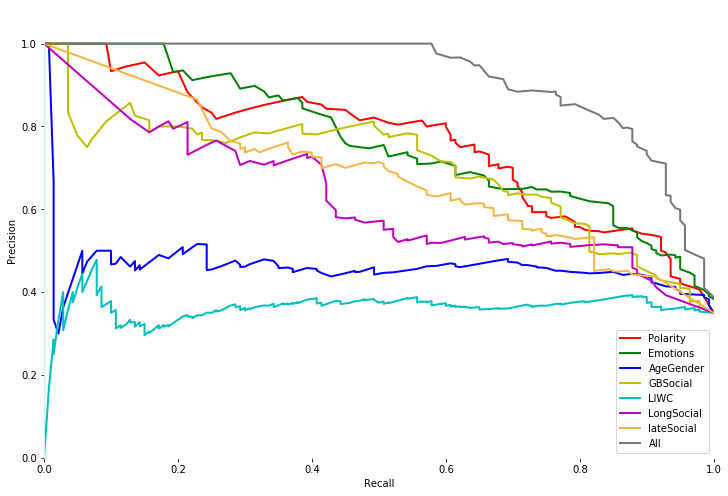

231 Normal and 121 Bipolar_3 in Training Data
26 Normal and 14 Bipolar_3 in Test Data



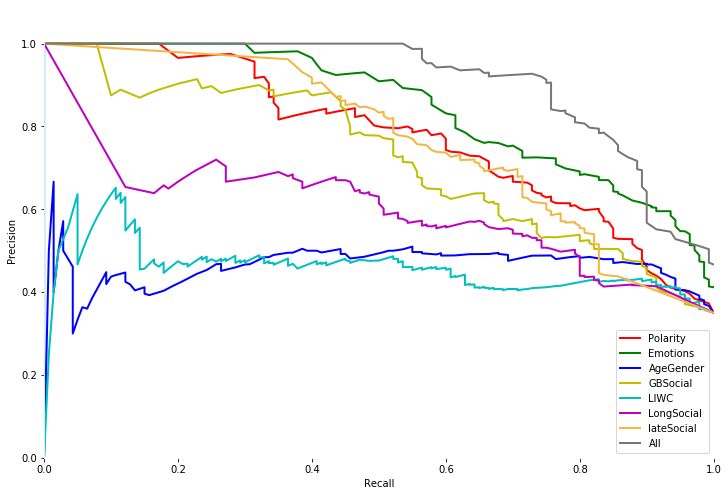

240 Normal and 111 Bipolar_6 in Training Data
27 Normal and 13 Bipolar_6 in Test Data



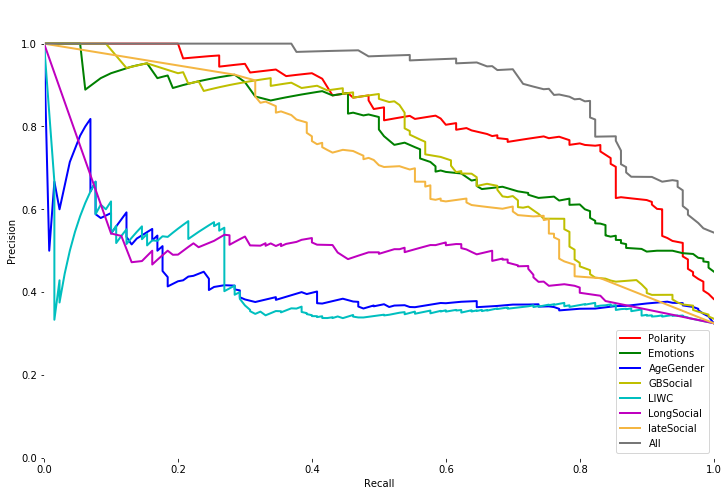

260 Normal and 105 Bipolar_9 in Training Data
29 Normal and 12 Bipolar_9 in Test Data



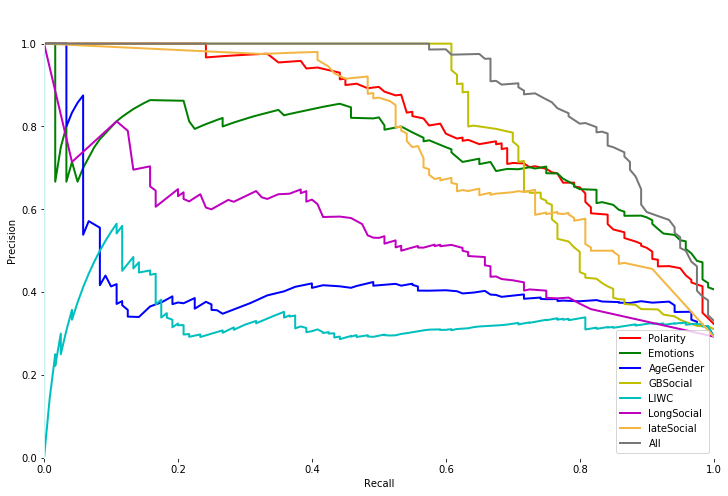

265 Normal and 100 Bipolar_12 in Training Data
30 Normal and 11 Bipolar_12 in Test Data



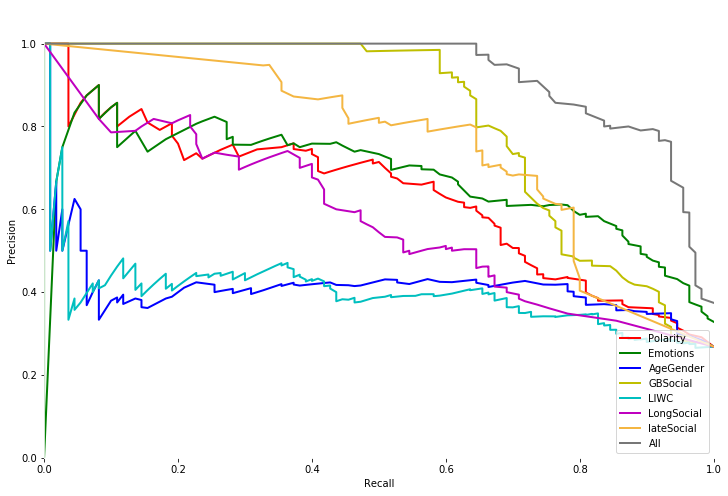

250 Normal and 100 Bipolar_15 in Training Data
28 Normal and 11 Bipolar_15 in Test Data



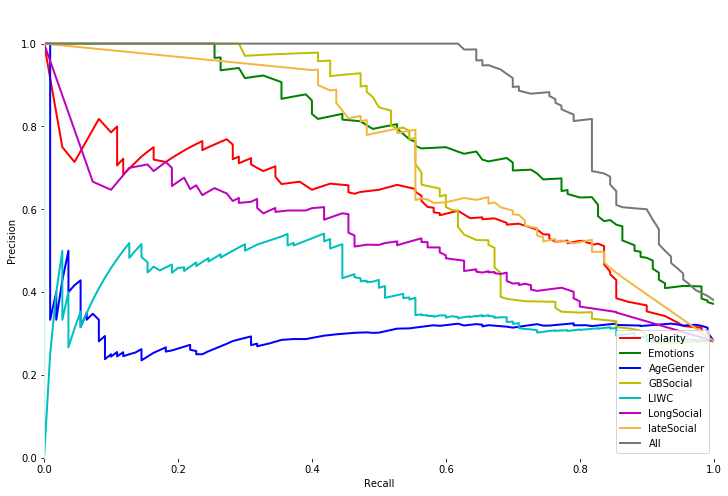

In [55]:
#Compare the performance of each Pattern of Life components and LIWC
pol_groups.renderPrecisionRecall_all("Bipolar_2", n_fold=10, consider_time = 2)
pol_groups.renderPrecisionRecall_all("Bipolar_3", n_fold=10, consider_time = 3)
pol_groups.renderPrecisionRecall_all("Bipolar_6", n_fold=10, consider_time = 6)
pol_groups.renderPrecisionRecall_all("Bipolar_9", n_fold=10, consider_time = 9)
pol_groups.renderPrecisionRecall_all("Bipolar_12", n_fold=10, consider_time = 12)
pol_groups.renderPrecisionRecall_all("Bipolar_15", n_fold=10, consider_time = 15)

234 Normal and 133 Bd_2 in Training Data
26 Normal and 15 Bd_2 in Test Data



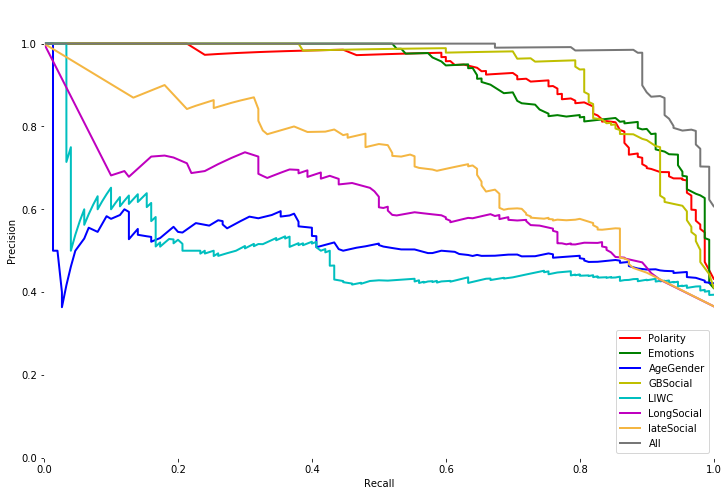

231 Normal and 125 Bd_3 in Training Data
26 Normal and 14 Bd_3 in Test Data



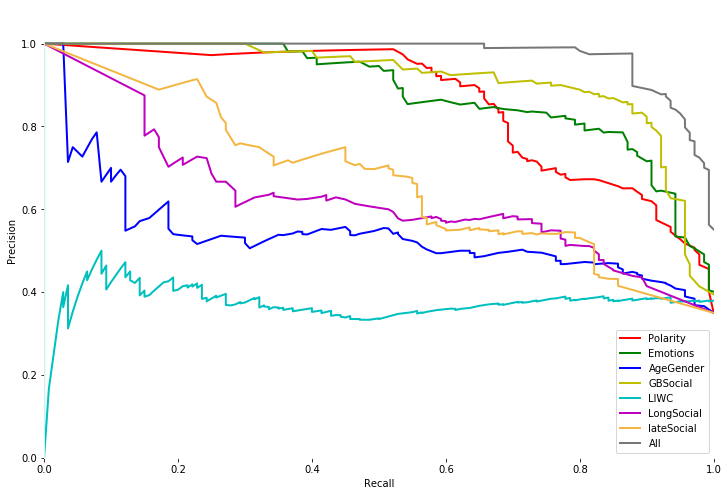

240 Normal and 120 Bd_6 in Training Data
27 Normal and 13 Bd_6 in Test Data



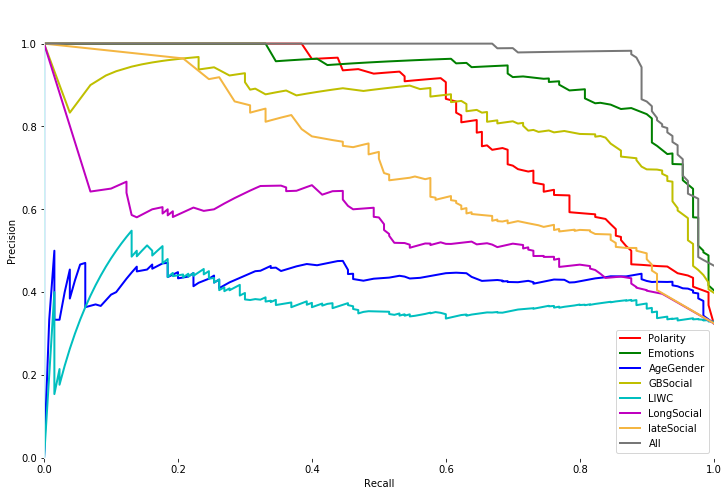

260 Normal and 115 Bd_9 in Training Data
29 Normal and 13 Bd_9 in Test Data



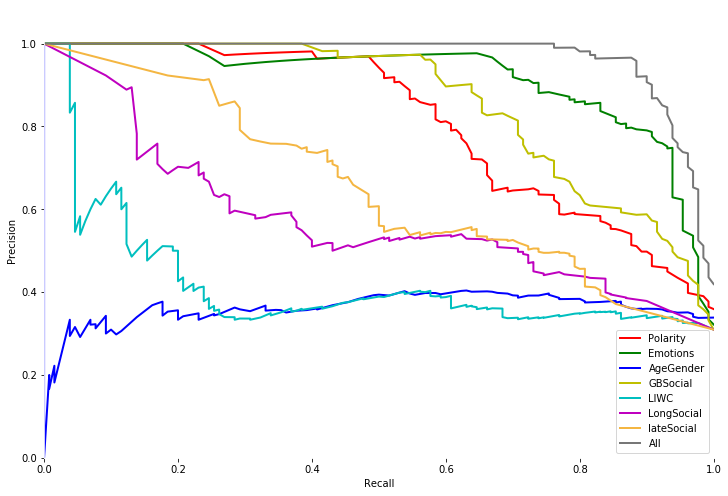

265 Normal and 106 Bd_12 in Training Data
30 Normal and 12 Bd_12 in Test Data



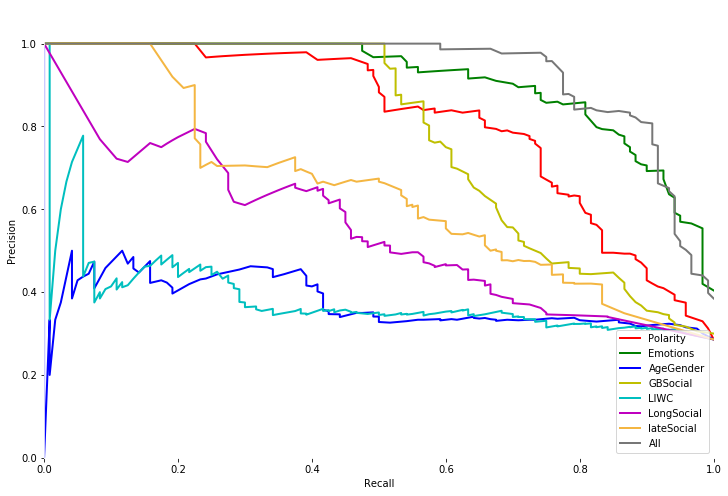

In [56]:
pol_groups_.renderPrecisionRecall_all("Bd_2", n_fold=10, consider_time = 2)
pol_groups_.renderPrecisionRecall_all("Bd_3", n_fold=10, consider_time = 3)
pol_groups_.renderPrecisionRecall_all("Bd_6", n_fold=10, consider_time = 6)
pol_groups_.renderPrecisionRecall_all("Bd_9", n_fold=10, consider_time = 9)
pol_groups_.renderPrecisionRecall_all("Bd_12", n_fold=10, consider_time = 12)

# Precission Recall Chart on 10-fold cross-validation

In [57]:
index2feature = pol_groups.index2feature

def getSelection(excluded_categories=[], excluded_index=[]):
    selection = []
    for i in range(len(index2feature)):
        name,category =  index2feature[i]
        if any(category == x for x in excluded_categories):
            #removed_features.append(name)
            pass
        elif any(name == x for x in excluded_index):
            #removed_features.append(name)
            pass

        else:                   
            selection.append(i)
    return selection


#ROC chart of three models:
# def renderROC(scores, labels,disorder ,names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted']):
def renderROC(scores, labels,disorder ,names,
              linestyle=['solid','solid','solid','solid','dashdot','dashdot','dashdot','dashdot'],
              colors = None,
              linewidth = 3,
              transparent = 1):
    
    fig, ax = plt.subplots()
    print("Under curve area")
    for i,(score, label) in enumerate(zip(scores, labels)):
        fpr, tpr, _ = roc_curve(label,score, pos_label=1)
        roc_auc = auc(fpr, tpr)
        
        if colors:
            plt.plot(fpr, tpr, label=names[i], ls=linestyle[i],linewidth=linewidth, color=colors[i], alpha=transparent)
        else:
            plt.plot(fpr, tpr, label=names[i], ls=linestyle[i],linewidth=linewidth, alpha=transparent)

        print("\t{:15} : {}".format(names[i],roc_auc))

   
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()

# , linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = ['r','g','b',"y","c","m","#f4b642","#777777"]
# def renderPRC(scores, labels, disorder ,names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = None):
def renderPRC(scores, labels, disorder ,names,
              linestyle=['solid','solid','solid','solid','dashdot','dashdot','dashdot','dashdot'],
              colors = None,
              linewidth = 3,
              transparent = 1):
    
    fig, ax = plt.subplots()
    print("Average Precision")
    for i,(score, label) in enumerate(zip(scores, labels)):        
        precision, recall, _ = precision_recall_curve(label, score, pos_label=1)
        average_precision = average_precision_score(label, score)
        
        if colors:
            plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=linewidth, color=colors[i], alpha=transparent)
        else:
            plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=linewidth, alpha=transparent)
            
        print("\t{:15} : {}".format(names[i],average_precision))

   

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Precision Recall Chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()

In [83]:
GBPOL_selection = getSelection(excluded_categories=["LIWC", "lateSocial", "LongSocial"])
latePOL_selection = getSelection(excluded_categories=["LIWC", "LongSocial"])
LongPOL_selection = getSelection(excluded_categories=["LIWC"])
LIWC_selection = getSelection(excluded_categories=["AgeGender", "Social", "Polarity", "Emotions", "lateSocial", "LongSocial"])

classifier  = RandomForestClassifier(n_jobs= -1, max_features="sqrt", n_estimators=128)
name = "Bipolar"
n_fold = 50


## Prepare all Needed Value for Chart

### POL

In [59]:
POL15_scores, POL15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 15)
POL12_scores, POL12_labels, _ = pol_groups.getLabelsScores(name+"_12", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 12)
POL9_scores, POL9_labels, _ = pol_groups.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 9)
POL6_scores, POL6_labels, _ = pol_groups.getLabelsScores(name+"_6", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 6)
POL3_scores, POL3_labels, _ = pol_groups.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 3)
POL2_scores, POL2_labels, _ = pol_groups.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 2)


### latePOL

In [84]:
latePOL15_scores, latePOL15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 15)
latePOL12_scores, latePOL12_labels, _ = pol_groups.getLabelsScores(name+"_12", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 12)
latePOL9_scores, latePOL9_labels, _ = pol_groups.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 9)
latePOL6_scores, latePOL6_labels, _ = pol_groups.getLabelsScores(name+"_6", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 6)
latePOL3_scores, latePOL3_labels, _ = pol_groups.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 3)
latePOL2_scores, latePOL2_labels, _ = pol_groups.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 2)

### longPOL

In [61]:
longPOL15_scores, longPOL15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 15)
longPOL12_scores, longPOL12_labels, _ = pol_groups.getLabelsScores(name+"_12", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 12)
longPOL9_scores, longPOL9_labels, _ = pol_groups.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 9)
longPOL6_scores, longPOL6_labels, _ = pol_groups.getLabelsScores(name+"_6", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 6)
longPOL3_scores, longPOL3_labels, _ = pol_groups.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 3)
longPOL2_scores, longPOL2_labels, _ = pol_groups.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 2)

### LIWC

In [62]:
LIWC15_scores, LIWC15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 15)
LIWC12_scores, LIWC12_labels, _ = pol_groups.getLabelsScores(name +"_12", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 12)
LIWC9_scores, LIWC9_labels, _ = pol_groups.getLabelsScores(name +"_9", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 9)
LIWC6_scores, LIWC6_labels, _ = pol_groups.getLabelsScores(name +"_6", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 6)
LIWC3_scores, LIWC3_labels, _ = pol_groups.getLabelsScores(name +"_3", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 3)
LIWC2_scores, LIWC2_labels, _ = pol_groups.getLabelsScores(name +"_2", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 2)

### TFIDF

In [63]:
tfidf15_scores, tfidf15_labels, _ = tfidf_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, consider_time = 15)
tfidf12_scores, tfidf12_labels, _ = tfidf_groups.getLabelsScores(name +"_12", classifier,n_fold=n_fold, consider_time = 12)
tfidf9_scores, tfidf9_labels, _ = tfidf_groups.getLabelsScores(name +"_9", classifier,n_fold=n_fold, consider_time = 9)
tfidf6_scores, tfidf6_labels, _ = tfidf_groups.getLabelsScores(name +"_6", classifier,n_fold=n_fold, consider_time = 6)
tfidf3_scores, tfidf3_labels, _ = tfidf_groups.getLabelsScores(name +"_3", classifier,n_fold=n_fold, consider_time = 3)
tfidf2_scores, tfidf2_labels, _ = tfidf_groups.getLabelsScores(name +"_2", classifier,n_fold=n_fold, consider_time = 2)

### Before Diagnosed time

In [64]:
name = 'Bd'

POL12_scores_, POL12_labels_, _ = pol_groups_.getLabelsScores(name+"_12", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 12)
POL9_scores_, POL9_labels_, _ = pol_groups_.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 9)
POL6_scores_, POL6_labels_, _ = pol_groups_.getLabelsScores(name+"_6", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 6)
POL3_scores_, POL3_labels_, _ = pol_groups_.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 3)
POL2_scores_, POL2_labels_, _ = pol_groups_.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 2)

latePOL12_scores_, latePOL12_labels_, _ = pol_groups_.getLabelsScores(name+"_12", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 12)
latePOL9_scores_, latePOL9_labels_, _ = pol_groups_.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 9)
latePOL6_scores_, latePOL6_labels_, _ = pol_groups_.getLabelsScores(name+"_6", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 6)
latePOL3_scores_, latePOL3_labels_, _ = pol_groups_.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 3)
latePOL2_scores_, latePOL2_labels_, _ = pol_groups_.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 2)

longPOL12_scores_, longPOL12_labels_, _ = pol_groups_.getLabelsScores(name+"_12", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 12)
longPOL9_scores_, longPOL9_labels_, _ = pol_groups_.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 9)
longPOL6_scores_, longPOL6_labels_, _ = pol_groups_.getLabelsScores(name+"_6", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 6)
longPOL3_scores_, longPOL3_labels_, _ = pol_groups_.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 3)
longPOL2_scores_, longPOL2_labels_, _ = pol_groups_.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 2)

LIWC12_scores_, LIWC12_labels_, _ = pol_groups_.getLabelsScores(name +"_12", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 12)
LIWC9_scores_, LIWC9_labels_, _ = pol_groups_.getLabelsScores(name +"_9", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 9)
LIWC6_scores_, LIWC6_labels_, _ = pol_groups_.getLabelsScores(name +"_6", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 6)
LIWC3_scores_, LIWC3_labels_, _ = pol_groups_.getLabelsScores(name +"_3", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 3)
LIWC2_scores_, LIWC2_labels_, _ = pol_groups_.getLabelsScores(name +"_2", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 2)

tfidf12_scores_, tfidf12_labels_, _ = tfidf_groups_.getLabelsScores(name +"_12", classifier,n_fold=n_fold, consider_time = 12)
tfidf9_scores_, tfidf9_labels_, _ = tfidf_groups_.getLabelsScores(name +"_9", classifier,n_fold=n_fold, consider_time = 9)
tfidf6_scores_, tfidf6_labels_, _ = tfidf_groups_.getLabelsScores(name +"_6", classifier,n_fold=n_fold, consider_time = 6)
tfidf3_scores_, tfidf3_labels_, _ = tfidf_groups_.getLabelsScores(name +"_3", classifier,n_fold=n_fold, consider_time = 3)
tfidf2_scores_, tfidf2_labels_, _ = tfidf_groups_.getLabelsScores(name +"_2", classifier,n_fold=n_fold, consider_time = 2)


### Traditional POL Comparation from Time Difference

Average Precision
	PoL(15month)    : 0.879318617803
	PoL(12month)    : 0.888839072363
	PoL(9month)     : 0.883833243538
	PoL(6month)     : 0.879822949464
	PoL(3month)     : 0.908712017162
	PoL(2month)     : 0.852951871332


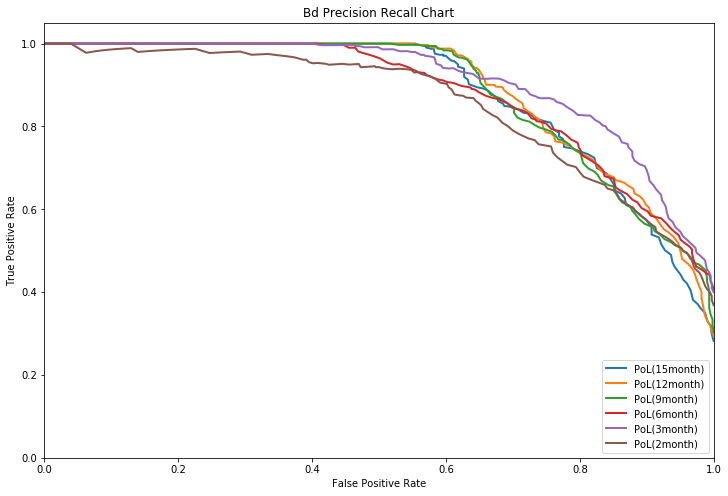

In [65]:
names = ["PoL(15month)","PoL(12month)", "PoL(9month)", "PoL(6month)","PoL(3month)", "PoL(2month)"]

bipolar_SCORES = [POL15_scores, POL12_scores, POL9_scores, POL6_scores, POL3_scores, POL2_scores]
bipolar_LABELS = [POL15_labels[:,0], POL12_labels[:,0], POL9_labels[:,0], POL6_labels[:,0], POL3_labels[:,0], POL2_labels[:,0]]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 2)


Average Precision
	PoL(12month)    : 0.973297117834
	PoL(9month)     : 0.978183461428
	PoL(6month)     : 0.969005537841
	PoL(3month)     : 0.982443970559
	PoL(2month)     : 0.974431869155


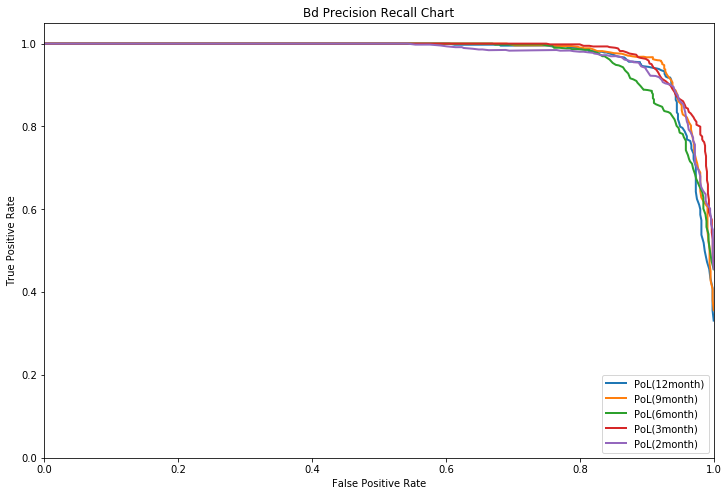

In [66]:
names = ["PoL(12month)", "PoL(9month)", "PoL(6month)","PoL(3month)", "PoL(2month)"]

bipolar_SCORES = [POL12_scores_, POL9_scores_, POL6_scores_, POL3_scores_, POL2_scores_]
bipolar_LABELS = [POL12_labels_[:,0], POL9_labels_[:,0], POL6_labels_[:,0], POL3_labels_[:,0], POL2_labels_[:,0]]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 2)


### Late POL Comparation from Time Difference

Average Precision
	latePoL(15month) : 0.891013664562
	latePoL(12month) : 0.902976449517
	latePoL(9month) : 0.90461304919
	latePoL(6month) : 0.894017631894
	latePoL(3month) : 0.908158398335
	latePoL(2month) : 0.85692096691


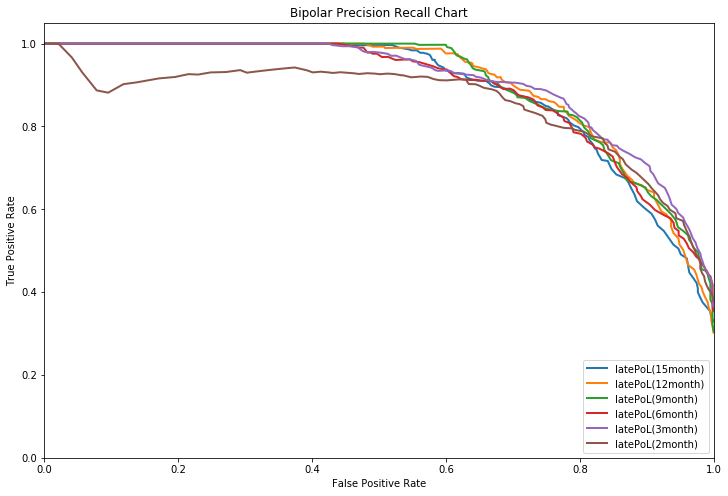

In [85]:
names = ["latePoL(15month)","latePoL(12month)", "latePoL(9month)", "latePoL(6month)","latePoL(3month)", "latePoL(2month)"]

bipolar_SCORES = [latePOL15_scores, latePOL12_scores, latePOL9_scores, latePOL6_scores, latePOL3_scores, latePOL2_scores]
bipolar_LABELS = [latePOL15_labels[:,0], latePOL12_labels[:,0], latePOL9_labels[:,0], latePOL6_labels[:,0], latePOL3_labels[:,0], latePOL2_labels[:,0]]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 2)

Average Precision
	latePoL(12month) : 0.970384046094
	latePoL(9month) : 0.973955209416
	latePoL(6month) : 0.971669072406
	latePoL(3month) : 0.976163872044
	latePoL(2month) : 0.976231519768


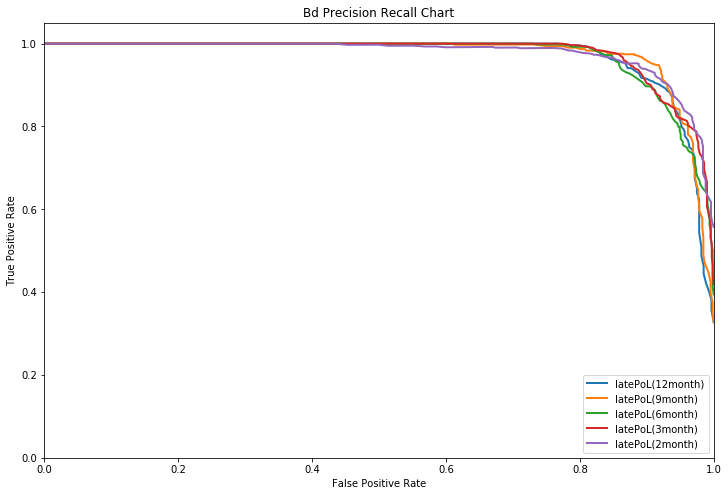

In [68]:
names = ["latePoL(12month)", "latePoL(9month)", "latePoL(6month)","latePoL(3month)", "latePoL(2month)"]

bipolar_SCORES = [latePOL12_scores_, latePOL9_scores_, latePOL6_scores_, latePOL3_scores_, latePOL2_scores_]
bipolar_LABELS = [latePOL12_labels_[:,0], latePOL9_labels_[:,0], latePOL6_labels_[:,0], latePOL3_labels_[:,0], latePOL2_labels_[:,0]]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 2)

### Long POL Comparation from Time Difference

Average Precision
	longPoL(15month) : 0.912286995054
	longPoL(12month) : 0.902891595162
	longPoL(9month) : 0.901079145683
	longPoL(6month) : 0.901904588852
	longPoL(3month) : 0.921352744019
	longPoL(2month) : 0.896484141739


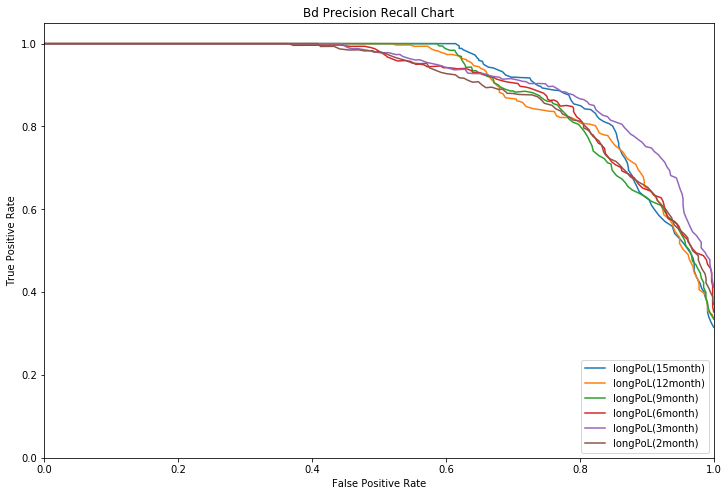

In [69]:
names = ["longPoL(15month)","longPoL(12month)", "longPoL(9month)", "longPoL(6month)","longPoL(3month)", "longPoL(2month)"]

bipolar_SCORES = [longPOL15_scores, longPOL12_scores, longPOL9_scores, longPOL6_scores, longPOL3_scores, longPOL2_scores]
bipolar_LABELS = [longPOL15_labels[:,0], longPOL12_labels[:,0], longPOL9_labels[:,0], longPOL6_labels[:,0], longPOL3_labels[:,0], longPOL2_labels[:,0]]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 1.5)


Average Precision
	longPoL(12month) : 0.971922442748
	longPoL(9month) : 0.97377242766
	longPoL(6month) : 0.975340869464
	longPoL(3month) : 0.982846122747
	longPoL(2month) : 0.984480593031


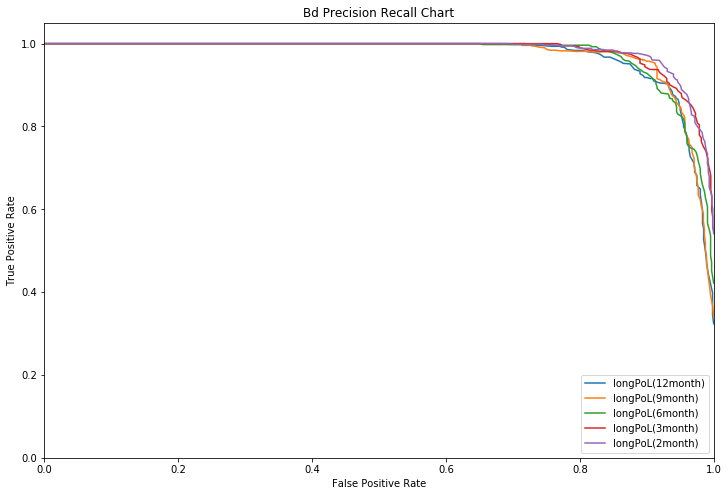

In [70]:
names = ["longPoL(12month)", "longPoL(9month)", "longPoL(6month)","longPoL(3month)", "longPoL(2month)"]

bipolar_SCORES = [longPOL12_scores_, longPOL9_scores_, longPOL6_scores_, longPOL3_scores_, longPOL2_scores_]
bipolar_LABELS = [longPOL12_labels_[:,0], longPOL9_labels_[:,0], longPOL6_labels_[:,0], longPOL3_labels_[:,0], longPOL2_labels_[:,0]]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 1.5)


### Compare LIWC

Average Precision
	LIWC(15month)   : 0.775878477939
	LIWC(12month)   : 0.779185872735
	LIWC(9month)    : 0.76858409052
	LIWC(6month)    : 0.775998483181
	LIWC(3month)    : 0.745654726288
	LIWC(2month)    : 0.710343127404


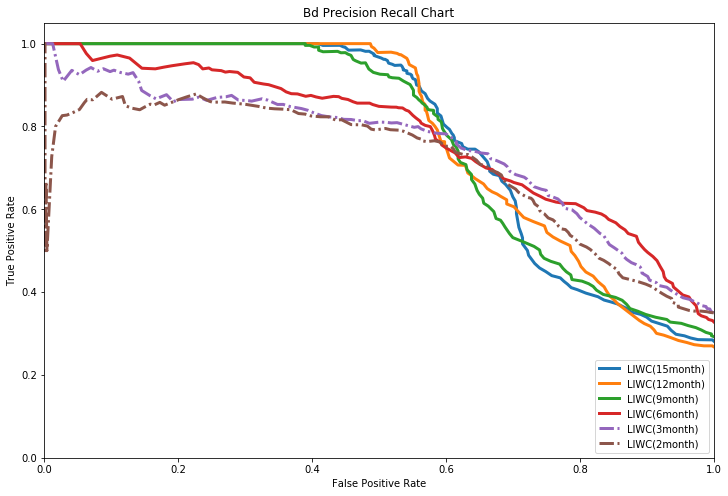

In [71]:
names = ["LIWC(15month)","LIWC(12month)", "LIWC(9month)", "LIWC(6month)","LIWC(3month)", "LIWC(2month)"]

bipolar_SCORES = [LIWC15_scores, LIWC12_scores, LIWC9_scores, LIWC6_scores, LIWC3_scores, LIWC2_scores]
bipolar_LABELS = [LIWC15_labels[:,0], LIWC12_labels[:,0], LIWC9_labels[:,0], LIWC6_labels[:,0], LIWC3_labels[:,0], LIWC2_labels[:,0]]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

Average Precision
	LIWC(12month)   : 0.771535794145
	LIWC(9month)    : 0.769612706253
	LIWC(6month)    : 0.758241768561
	LIWC(3month)    : 0.876006797127
	LIWC(2month)    : 0.900882055562


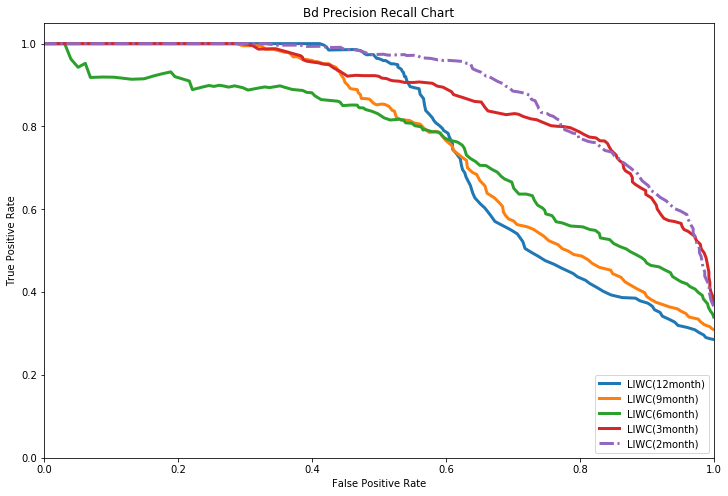

In [72]:
names = ["LIWC(12month)", "LIWC(9month)", "LIWC(6month)","LIWC(3month)", "LIWC(2month)"]

bipolar_SCORES = [LIWC12_scores_, LIWC9_scores_, LIWC6_scores_, LIWC3_scores_, LIWC2_scores_]
bipolar_LABELS = [LIWC12_labels_[:,0], LIWC9_labels_[:,0], LIWC6_labels_[:,0], LIWC3_labels_[:,0], LIWC2_labels_[:,0]]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

### TFIDF

Average Precision
	tfidf(15month)  : 0.849842676549
	tfidf(12month)  : 0.830824876327
	tfidf(9month)   : 0.851118922416
	tfidf(6month)   : 0.86909381326
	tfidf(3month)   : 0.874554648746
	tfidf(2month)   : 0.841764936083


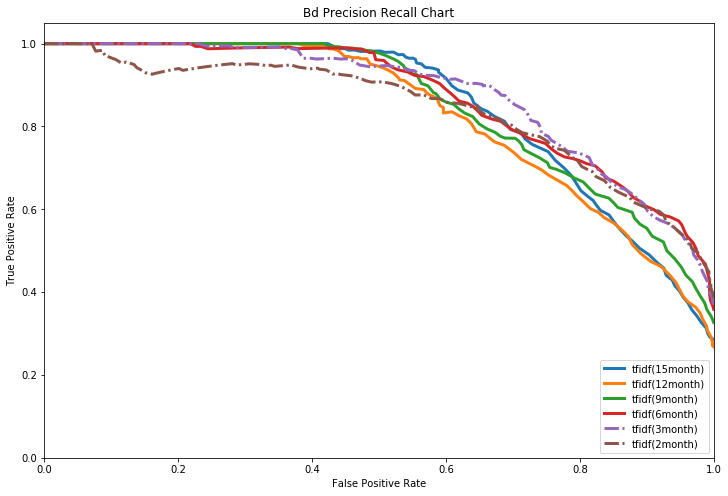

In [73]:
names = ["tfidf(15month)","tfidf(12month)", "tfidf(9month)", "tfidf(6month)","tfidf(3month)", "tfidf(2month)"]

bipolar_SCORES = [tfidf15_scores, tfidf12_scores, tfidf9_scores, tfidf6_scores, tfidf3_scores, tfidf2_scores]
bipolar_LABELS = [tfidf15_labels, tfidf12_labels, tfidf9_labels, tfidf6_labels, tfidf3_labels, tfidf2_labels]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

Average Precision
	tfidf(12month)  : 0.833722930791
	tfidf(9month)   : 0.844840282377
	tfidf(6month)   : 0.867585736828
	tfidf(3month)   : 0.920004699004
	tfidf(2month)   : 0.940791828102


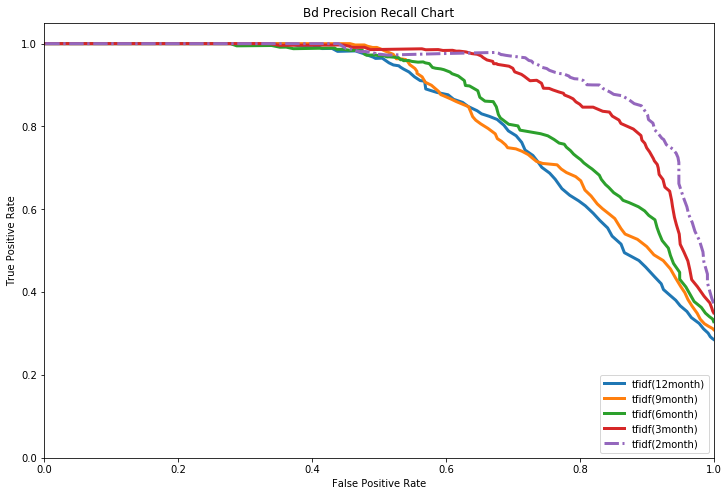

In [74]:
names = ["tfidf(12month)", "tfidf(9month)", "tfidf(6month)","tfidf(3month)", "tfidf(2month)"]

bipolar_SCORES = [tfidf12_scores_, tfidf9_scores_, tfidf6_scores_, tfidf3_scores_, tfidf2_scores_]
bipolar_LABELS = [tfidf12_labels_, tfidf9_labels_, tfidf6_labels_, tfidf3_labels_, tfidf2_labels_]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

### Compare POL, LIWC, TFIDF

Under curve area
	PoL(15month)    : 0.920985064935
	TFIDF(15month)  : 0.897645454545
	LIWC(15month)   : 0.809462987013


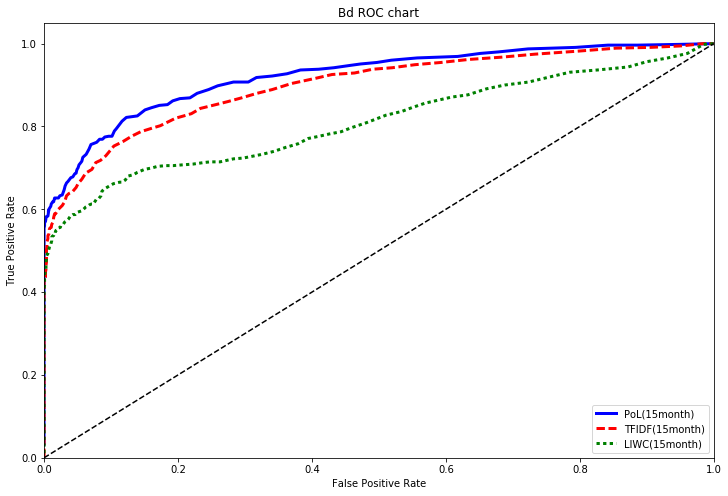

Average Precision
	PoL(15month)    : 0.879318617803
	TFIDF(15month)  : 0.849842676549
	LIWC(15month)   : 0.775878477939


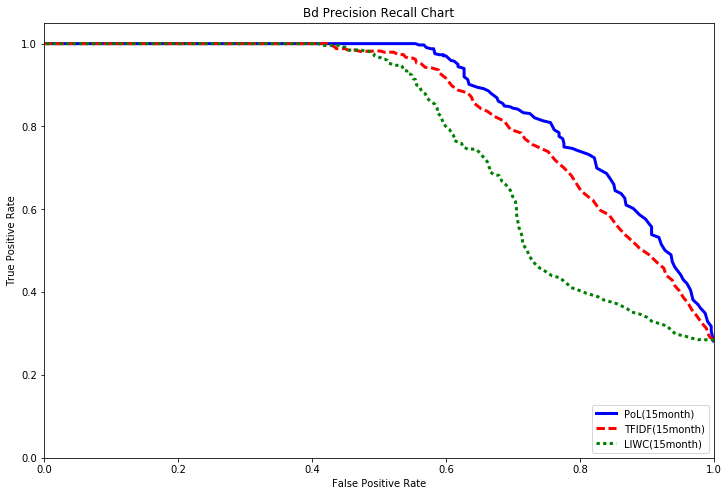

In [75]:
names = ["PoL(15month)", "TFIDF(15month)", "LIWC(15month)"]

bipolar_SCORES = [POL15_scores, tfidf15_scores, LIWC15_scores]
bipolar_LABELS = [POL15_labels[:,0], tfidf15_labels, LIWC15_labels[:,0]]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])

Under curve area
	PoL(15month)    : 0.920985064935
	latePoL(15month) : 0.935512337662
	LongPoL(15month) : 0.944887012987
	TFIDF(15month)  : 0.897645454545
	LIWC(15month)   : 0.809462987013


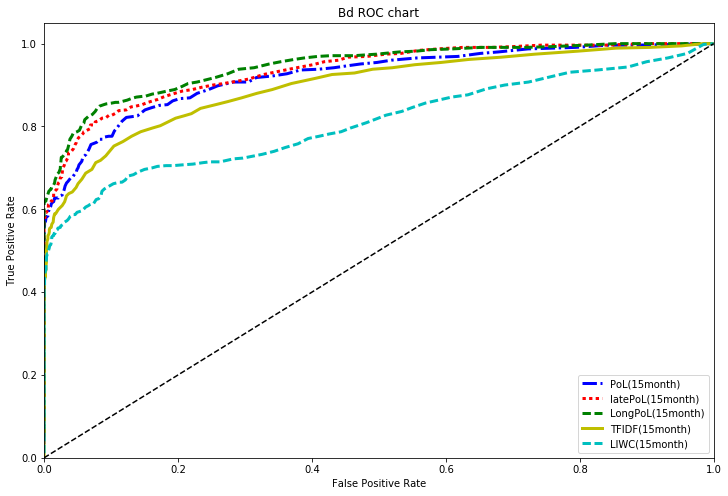

Average Precision
	PoL(15month)    : 0.879318617803
	latePoL(15month) : 0.898258972588
	LongPoL(15month) : 0.912286995054
	TFIDF(15month)  : 0.849842676549
	LIWC(15month)   : 0.775878477939


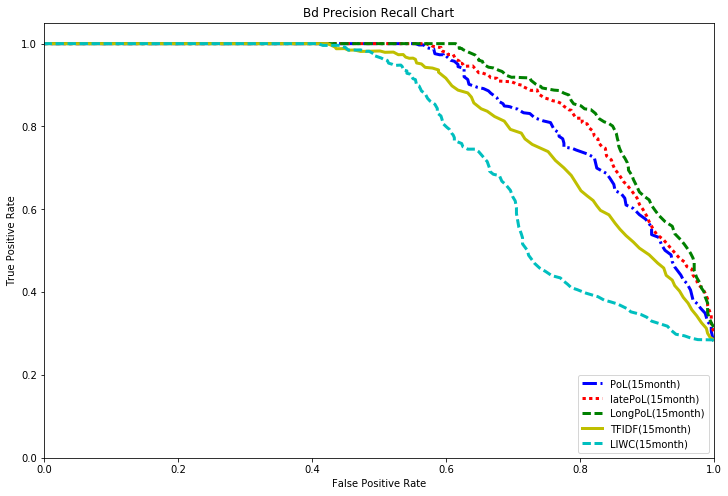

In [76]:
names = ["PoL(15month)", "latePoL(15month)", "LongPoL(15month)", "TFIDF(15month)", "LIWC(15month)"]

bipolar_SCORES = [POL15_scores, latePOL15_scores, longPOL15_scores, tfidf15_scores, LIWC15_scores]
bipolar_LABELS = [POL15_labels[:,0], latePOL15_labels[:,0], longPOL15_labels[:,0], tfidf15_labels, LIWC15_labels[:,0]]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names, linestyle=['dashdot',':','--','solid','dashed','','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['dashdot',':','--','solid','dashed','solid','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])

Average Precision
	PoL(12month)    : 0.973297117834
	latePoL(12month) : 0.970384046094
	LongPoL(12month) : 0.971922442748
	TFIDF(12month)  : 0.833722930791
	LIWC(12month)   : 0.771535794145


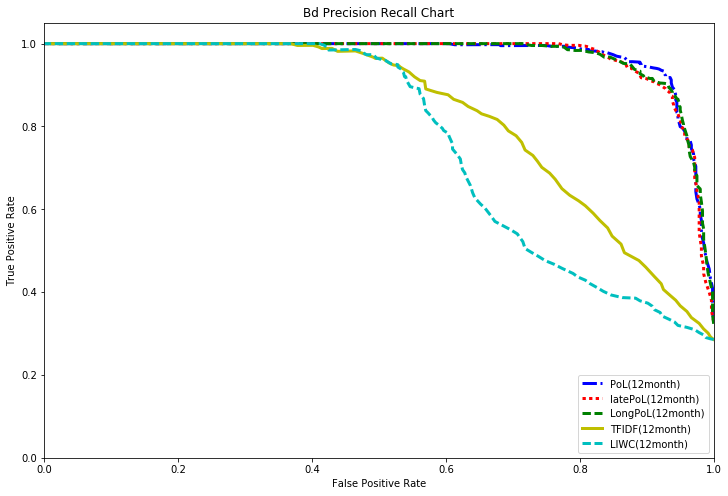

In [77]:
names = ["PoL(12month)", "latePoL(12month)", "LongPoL(12month)", "TFIDF(12month)", "LIWC(12month)"]

bipolar_scores_ = [POL12_scores_, latePOL12_scores_, longPOL12_scores_, tfidf12_scores_, LIWC12_scores_]
bipolar_labels_ = [POL12_labels_[:,0], latePOL12_labels_[:,0], longPOL12_labels_[:,0], tfidf12_labels_, LIWC12_labels_[:,0]]

renderPRC(bipolar_scores_, bipolar_labels_, name, names, linestyle=['dashdot',':','--','solid','dashed','solid','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])

Under curve area
	PoL(3month)     : 0.932847802198
	latePoL(3month) : 0.929873626374
	LongPoL(3month) : 0.94658956044
	TFIDF(3month)   : 0.820504945055
	LIWC(3month)    : 0.909314835165


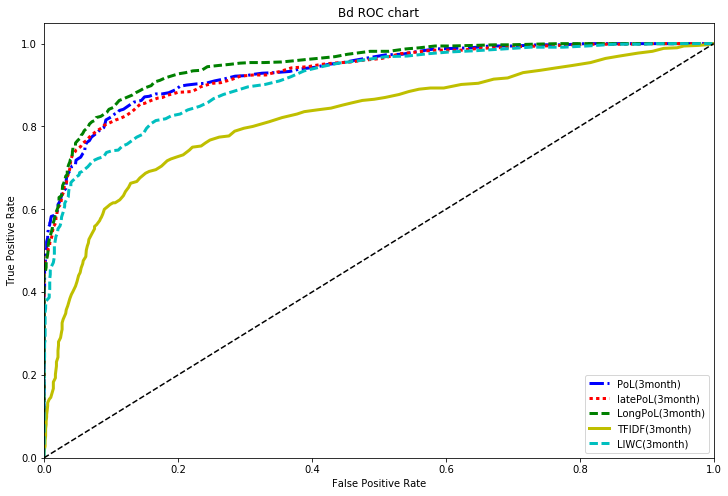

Average Precision
	PoL(3month)     : 0.908712017162
	latePoL(3month) : 0.905414852555
	LongPoL(3month) : 0.921352744019
	TFIDF(3month)   : 0.745654726288
	LIWC(3month)    : 0.874554648746


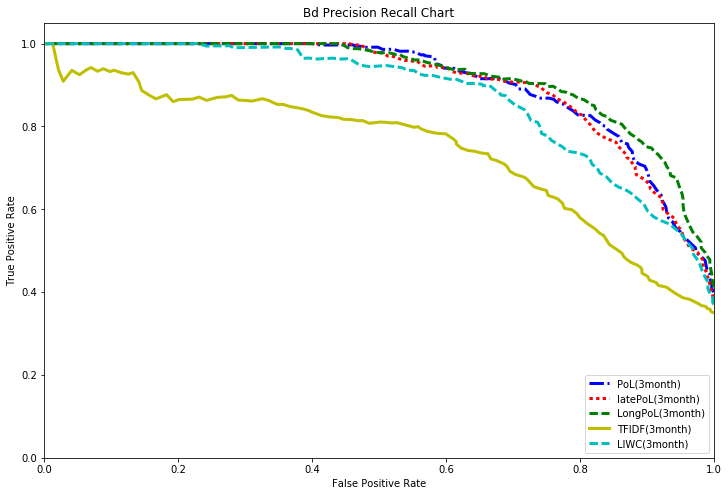

In [78]:
names = ["PoL(3month)", "latePoL(3month)", "LongPoL(3month)", "TFIDF(3month)", "LIWC(3month)"]

bipolar_SCORES = [POL3_scores, latePOL3_scores, longPOL3_scores, LIWC3_scores, tfidf3_scores]
bipolar_LABELS = [POL3_labels[:,0], latePOL3_labels[:,0], longPOL3_labels[:,0], LIWC3_labels[:,0], tfidf3_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names, linestyle=['dashdot',':','--','solid','dashed','','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['dashdot',':','--','solid','dashed','','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])

Average Precision
	PoL(3month)     : 0.982443970559
	latePoL(3month) : 0.976163872044
	LongPoL(3month) : 0.982846122747
	TFIDF(3month)   : 0.920004699004
	LIWC(3month)    : 0.876006797127


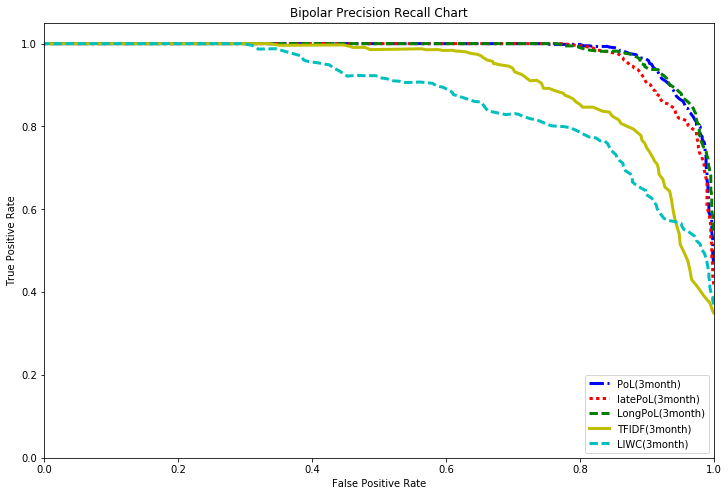

In [87]:
names = ["PoL(3month)", "latePoL(3month)", "LongPoL(3month)", "TFIDF(3month)", "LIWC(3month)"]

bipolar_scores_ = [POL3_scores_, latePOL3_scores_, longPOL3_scores_, tfidf3_scores_, LIWC3_scores_]
bipolar_labels_ = [POL3_labels_[:,0], latePOL3_labels_[:,0], longPOL3_labels_[:,0], tfidf3_labels_, LIWC3_labels_[:,0]]

renderPRC(bipolar_scores_, bipolar_labels_, name, names, linestyle=['dashdot',':','--','solid','dashed','solid','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])

Average Precision
	PoL(2month)     : 0.974431869155
	latePoL(2month) : 0.976231519768
	LongPoL(2month) : 0.984480593031
	TFIDF(2month)   : 0.940791828102
	LIWC(2month)    : 0.900882055562


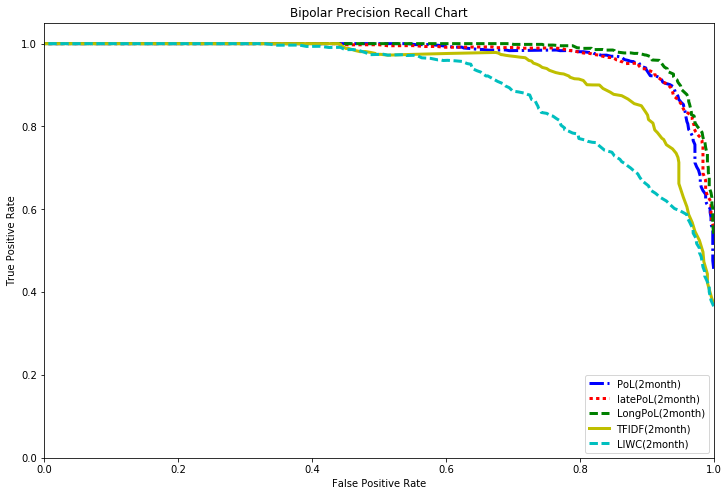

In [86]:
names = ["PoL(2month)", "latePoL(2month)", "LongPoL(2month)", "TFIDF(2month)", "LIWC(2month)"]

bipolar_scores_ = [POL2_scores_, latePOL2_scores_, longPOL2_scores_, tfidf2_scores_, LIWC2_scores_]
bipolar_labels_ = [POL2_labels_[:,0], latePOL2_labels_[:,0], longPOL2_labels_[:,0], tfidf2_labels_, LIWC2_labels_[:,0]]

renderPRC(bipolar_scores_, bipolar_labels_, name, names, linestyle=['dashdot',':','--','solid','dashed','solid','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])

Under curve area
	PoL(15month)    : 0.920985064935
	PoL(9month)     : 0.927106896552
	PoL(3month)     : 0.932847802198
	PoL(2month)     : 0.89453021978
	TFIDF(15month)  : 0.897645454545
	TFIDF(9month)   : 0.907466666667
	TFIDF(3month)   : 0.909314835165
	TFIDF(2month)   : 0.901029120879


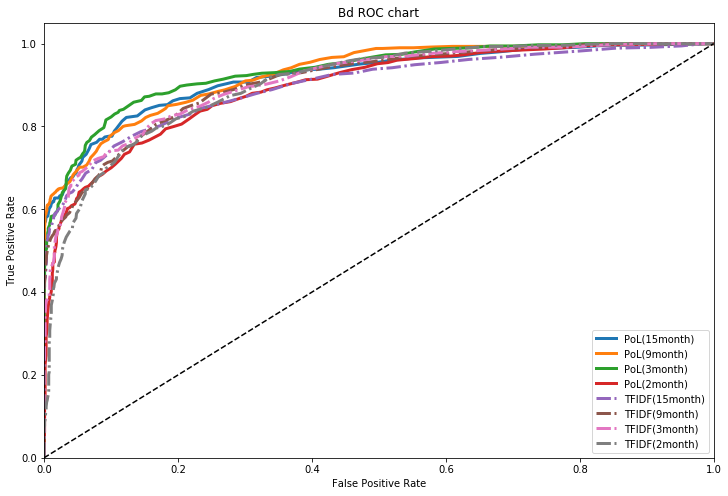

Average Precision
	PoL(15month)    : 0.879318617803
	PoL(9month)     : 0.883833243538
	PoL(3month)     : 0.908712017162
	PoL(2month)     : 0.852951871332
	TFIDF(15month)  : 0.849842676549
	TFIDF(9month)   : 0.851118922416
	TFIDF(3month)   : 0.874554648746
	TFIDF(2month)   : 0.841764936083


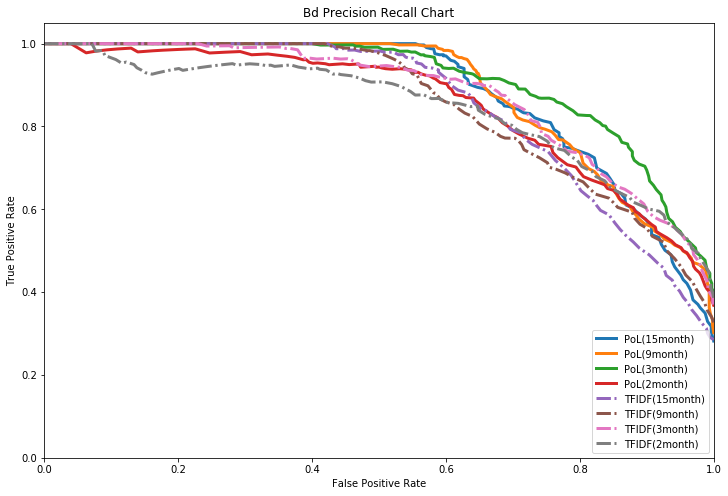

In [79]:
names = ["PoL(15month)", "PoL(9month)", "PoL(3month)", "PoL(2month)", "TFIDF(15month)", "TFIDF(9month)", "TFIDF(3month)", "TFIDF(2month)"]

bipolar_SCORES = [POL15_scores, POL9_scores, POL3_scores, POL2_scores,
                  tfidf15_scores, tfidf9_scores, tfidf3_scores, tfidf2_scores]
bipolar_LABELS = [POL15_labels[:,0], POL9_labels[:,0], POL3_labels[:,0], POL2_labels[:,0], 
                  tfidf15_labels, tfidf9_labels, tfidf3_labels, tfidf2_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names)  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

# latePOL_scores, latePOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = "short")
# LongPOL_scores, LongPOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = "short")



Under curve area
	latePoL(15month) : 0.920985064935
	latePoL(9month) : 0.927106896552
	latePoL(3month) : 0.932847802198
	latePoL(2month) : 0.89453021978
	TFIDF(15month)  : 0.897645454545
	TFIDF(9month)   : 0.907466666667
	TFIDF(3month)   : 0.909314835165
	TFIDF(2month)   : 0.901029120879


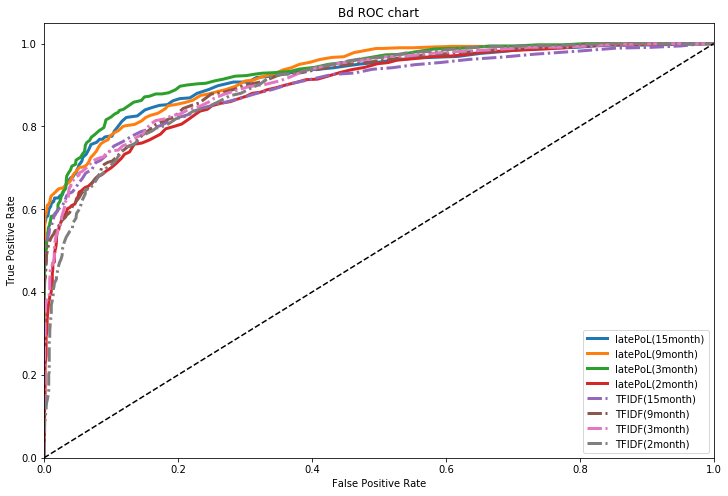

Average Precision
	latePoL(15month) : 0.879318617803
	latePoL(9month) : 0.883833243538
	latePoL(3month) : 0.908712017162
	latePoL(2month) : 0.852951871332
	TFIDF(15month)  : 0.849842676549
	TFIDF(9month)   : 0.851118922416
	TFIDF(3month)   : 0.874554648746
	TFIDF(2month)   : 0.841764936083


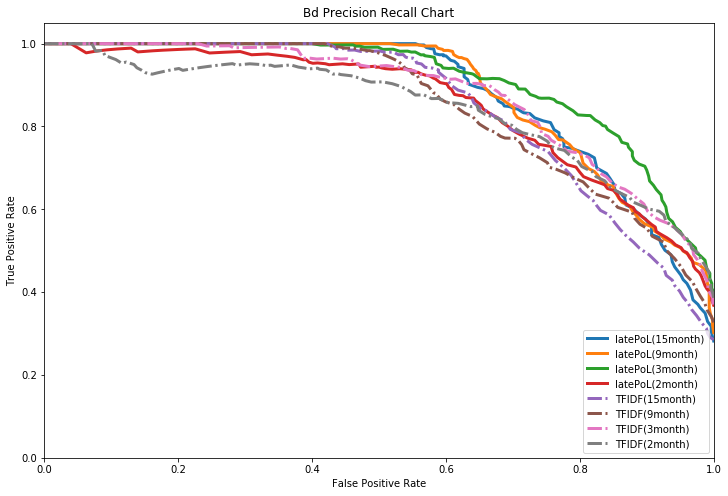

In [80]:
names = ["latePoL(15month)", "latePoL(9month)", "latePoL(3month)", "latePoL(2month)", "TFIDF(15month)", "TFIDF(9month)", "TFIDF(3month)", "TFIDF(2month)"]

bipolar_SCORES = [POL15_scores, POL9_scores, POL3_scores, POL2_scores,
                  tfidf15_scores, tfidf9_scores, tfidf3_scores, tfidf2_scores]
bipolar_LABELS = [POL15_labels[:,0], POL9_labels[:,0], POL3_labels[:,0], POL2_labels[:,0], 
                  tfidf15_labels, tfidf9_labels, tfidf3_labels, tfidf2_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names)  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

Under curve area
	longPoL(15month) : 0.920985064935
	longPoL(9month) : 0.927106896552
	longPoL(3month) : 0.932847802198
	longPoL(2month) : 0.89453021978
	TFIDF(15month)  : 0.897645454545
	TFIDF(9month)   : 0.907466666667
	TFIDF(3month)   : 0.909314835165
	TFIDF(2month)   : 0.901029120879


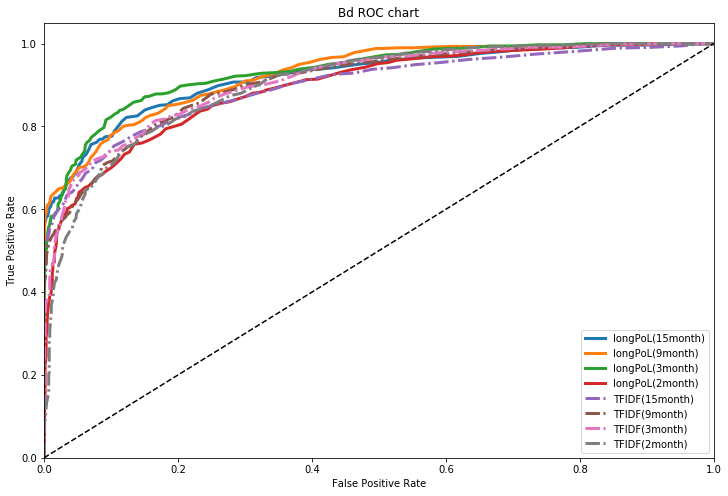

Average Precision
	longPoL(15month) : 0.879318617803
	longPoL(9month) : 0.883833243538
	longPoL(3month) : 0.908712017162
	longPoL(2month) : 0.852951871332
	TFIDF(15month)  : 0.849842676549
	TFIDF(9month)   : 0.851118922416
	TFIDF(3month)   : 0.874554648746
	TFIDF(2month)   : 0.841764936083


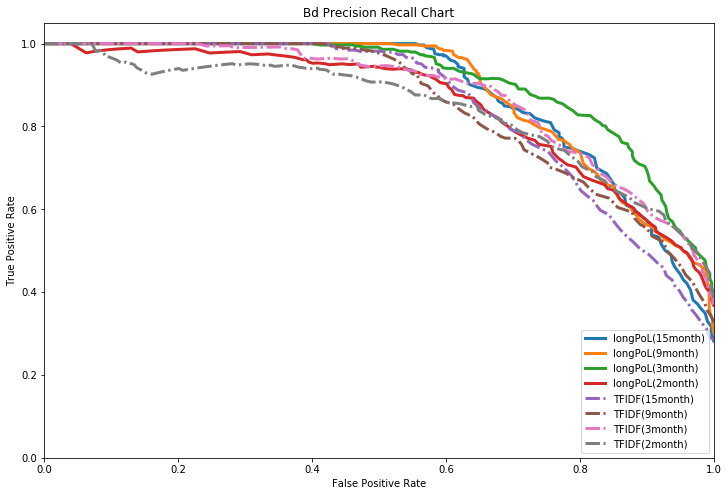

In [81]:
names = ["longPoL(15month)", "longPoL(9month)", "longPoL(3month)", "longPoL(2month)", "TFIDF(15month)", "TFIDF(9month)", "TFIDF(3month)", "TFIDF(2month)"]
bipolar_SCORES = [POL15_scores, POL9_scores, POL3_scores, POL2_scores,
                  tfidf15_scores, tfidf9_scores, tfidf3_scores, tfidf2_scores]
bipolar_LABELS = [POL15_labels[:,0], POL9_labels[:,0], POL3_labels[:,0], POL2_labels[:,0], 
                  tfidf15_labels, tfidf9_labels, tfidf3_labels, tfidf2_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names)  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

In [ ]:
# Old
# names = ["PoL(GB)", "LIWC(GB)", "TF-IDF(GB)", "PoL", "time-PoL(late)", "time-PoL", "LIWC", "TF-IDF"]
# GBPOL_scores, GBPOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = "long")
# POL_scores, POL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = "short")
# LongLIWC_scores, LongLIWC_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = "long")
# LIWC_scores, LIWC_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = "short")
# latePOL_scores, latePOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = "short")
# LongPOL_scores, LongPOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = "short")
# Longtfidf_scores, Longtfidf_labels, _ = tfidf_groups.getLabelsScores("Long_Bipolar", classifier,n_fold=n_fold, consider_time = "long")
# tfidf_scores, tfidf_labels, _ = tfidf_groups.getLabelsScores(name, classifier,n_fold=n_fold, consider_time = "short")

# bipolar_SCORES = [GBPOL_scores, LongLIWC_scores, Longtfidf_scores, POL_scores, latePOL_scores, LongPOL_scores , LIWC_scores, tfidf_scores]
# bipolar_LABELS = [GBPOL_labels[:,0], LongLIWC_labels[:,0], Longtfidf_labels, POL_labels[:,0], latePOL_labels[:,0], LongPOL_labels[:,0], LIWC_labels[:,0], tfidf_labels]
# bipolar_NAMES =  [GBPOL_labels[:,1], LIWC_labels[:,1], latePOL_labels[:,1], POL_labels[:,1], LongPOL_labels[:,1]]

# renderROC(bipolar_SCORES, bipolar_LABELS, name,names)  
# renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

In [291]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

### Compare Dataset by TFIDF Model

In [88]:
# Load model
tfidf_rf_classifier = joblib.load("models/tfidf/tfidf_forest_classifier")
# tfidf_text_model = joblib.load("models/tfidf/tfidf_text_model_new")

In [89]:
import scipy.sparse as sp

idfs = np.load("models/tfidf/idf.npy")

# subclass TfidfVectorizer
class MyVectorizer(TfidfVectorizer):
    # plug our pre-computed IDFs
    TfidfVectorizer.idf_ = idfs
    
# instantiate vectorizer
text_model = MyVectorizer(stop_words="english", 
                          ngram_range = (1,2))


# plug _tfidf._idf_diag
text_model._tfidf._idf_diag = sp.spdiags(idfs,
                                         diags = 0,
                                         m = len(idfs),
                                         n = len(idfs))

vocabulary = json.load(open('models/tfidf/vocabulary.json', mode = 'rb'))
text_model.vocabulary_ = vocabulary

In [90]:

feature_indicies = np.argsort(tfidf_rf_classifier.feature_importances_)
vector2word = text_model.get_feature_names()
top_words = []
for i in range(50):
    vector = feature_indicies[-i-1]
    word = vector2word[vector]
    top_words.append(word)

In [91]:
print(top_words)

[u'bipolar', u'mental illness', u'mental', u'therapy', u'diagnosed', u'coping', u'health issues', u'disorder', u'stigma', u'disability', u'mania', u'mental health', u'bipolardisorder', u'life bipolar', u'antidepressants', u'borderline', u'nami', u'manic', u'bpd', u'helping', u'timetochange', u'mentally', u'meds', u'pills', u'reading', u'depressive', u'manic episode', u'psych', u'exercise', u'anxiety', u'psychiatrist', u'diagnosis', u'blogs', u'suicide', u'nurse_w_glasses', u'personality disorder', u'struggling', u'stable', u'article', u'tickets', u'self', u'stress', u'share', u'survivors', u'manic depression', u'new blog', u'anxious', u'depression', u'hypomania', u'mentally ill']


In [92]:
def del_url(line):
    return re.sub(r'(\S*(\.com)\S*)|(https?:\/\/\S*)', "", line)

In [70]:
name_list = [2,3,6,9,12,15]
bipolar_group_list = [bipolar2_group, bipolar3_group, bipolar6_group, bipolar9_group, bipolar12_group, bipolar15_group]
for i, groups in enumerate(bipolar_group_list):
    X = text_model.transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in groups.getGroup()])
    print('Recall of {:>2d} month data : {}'.format(name_list[i], tfidf_rf_classifier.predict(X).mean()))

Recall of  2 month data : 0.210526315789
Recall of  3 month data : 0.222222222222
Recall of  6 month data : 0.193548387097
Recall of  9 month data : 0.213675213675
Recall of 12 month data : 0.234234234234
Recall of 15 month data : 0.207207207207


## Compare by different Classifier Via Recent Diagnosed Data

Baseline & Out Approach

In [143]:
time_list = [2,3,6,9,12,15]
name_list = ["Bipolar_2", "Bipolar_3", "Bipolar_6", "Bipolar_9", "Bipolar_12", "Bipolar_15"]

def getTFIDFClassifier(name = 'Bipolar', tfidf_groups = tfidf_groups, consider_time = 2):
    group_id = tfidf_groups.name_to_index[name + '_' + str(consider_time)]
    group = tfidf_groups.groups[group_id]
    X = tfidf_groups.text_models[group_id].transform(tfidf_groups.base.getTexts()+group.getTexts())
    Y =  np.array([0] * tfidf_groups.base.getSize() + [1] * group.getSize())
    
    classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
    classifier.fit(X,Y)
    
    return classifier

def getClassifier( feature_group, name, selection="all", consider_time = 'short', n_fold = 20):
    classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
    
    X, Y = feature_group.getLabeledData( name, selection=selection, consider_time= consider_time)

    sss = StratifiedShuffleSplit(Y[:,0], n_fold, test_size = 0.1, random_state=randint(0,65536) )
    
    classifiers = []
    for train_index, test_index in sss:
        X_train, X_test           = X[train_index], X[test_index]
        Y_train, Y_test           = Y[train_index][:,0], Y[test_index][:,0]

        classifier.fit(X_train, Y_train)
        classifiers.append(classifier)

    return classifiers


def renderPrecision(selection, 
                    base_feature, 
                    pol_groups = pol_groups, 
                    name_list = name_list, 
                    time_list = time_list, 
                    Y = None):
    test_feature = base_feature[:,selection]
    classifiers_list = [getClassifier(pol_groups, name, selection = selection, consider_time = time_list[i]) for i, name in enumerate(name_list)] 
    result_list = []
    if Y == None:
        for i, classifiers in enumerate(classifiers_list):
            SCORES = np.array([])
            for classifier in classifiers:
                SCORES = np.concatenate((SCORES, classifier.predict(test_feature)))
            result_list.append(SCORES.mean())
        return result_list
    else:
        for i, classifiers in enumerate(classifiers_list):
            SCORES = np.array([])
            for classifier in classifiers:
                SCORES = np.concatenate((SCORES, average_precision_score(Y, classifier.predict(test_feature))))
            result_list.append(SCORES.mean())
        return result_list

In [95]:
# Testing Data organize 
def getTestFeatures(recent_group):
    feature2categories = getCategories(recent_group)
    feature_dict = getAllFeature(recent_group)
    index2feature = []
    base_feature = np.zeros((recent_group.getSize(),len(feature_dict)), dtype = float)
    for name, values in feature_dict.items():
        cursor = len(index2feature)
        base_feature[:,cursor] = values
        category = feature2categories[name]
        index2feature.append((name, category))

    return base_feature

### Time Period Feature Classifier

### Baseline Classifier

In [94]:
gb_thesis_classifier = joblib.load('models/bipolar_forest/bipolar_forest_gb_thesis')
GB_Thesis_selection = [4, 10, 11, 12, 13, 15, 18, 22, 25, 35, 39, 46, 52, 60, 17, 65, 66, 69, 78]

### Table

In [61]:
tfidf_classifiers = [getTFIDFClassifier(consider_time = 2), 
                    getTFIDFClassifier(consider_time = 3), 
                    getTFIDFClassifier(consider_time = 6), 
                    getTFIDFClassifier(consider_time = 9), 
                    getTFIDFClassifier(consider_time = 12), 
                    getTFIDFClassifier(consider_time = 15)]

In [103]:
tfidf_classifiers_ = [getTFIDFClassifier(name = 'Bd', tfidf_groups = tfidf_groups_, consider_time = 2), 
                    getTFIDFClassifier(name = 'Bd', tfidf_groups = tfidf_groups_, consider_time = 3), 
                    getTFIDFClassifier(name = 'Bd', tfidf_groups = tfidf_groups_, consider_time = 6), 
                    getTFIDFClassifier(name = 'Bd', tfidf_groups = tfidf_groups_, consider_time = 9), 
                    getTFIDFClassifier(name = 'Bd', tfidf_groups = tfidf_groups_, consider_time = 12)]

In [375]:
b_feature = getTestFeatures(recent_group5)
r_feature = getTestFeatures(test_regular_group5)
X = np.concatenate((b_feature, r_feature))
Y = np.array([1]*b_feature.shape[0] + [0]*r_feature.shape[0])

In [383]:
text_array = text_model.transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in recent_group5.getGroup()] +
                                              ["\n".join(map(lambda x : del_url(x), group.text)) for group in test_regular_group5.getGroup()])

In [402]:
# indices = np.argsort(text_model.idf_)[::-1]
# features = text_model.get_feature_names()
# top_n = 1000
# top_features = [features[i] for i in indices[:top_n]]
# print top_features

In [158]:
# skip last 2 month
headers = ["Feature","2 month", "3 month","6 month","9 month", "12 month", "15 month"]
feature_names = ['Base_Pol', 'Base_TFIDF','Pol', 'Late Pol', 'Long Pol', 'LIWC', 'TFIDF','TFIDFxLPol']
selections = [GB_Thesis_selection, 'btfidf', GBPOL_selection, latePOL_selection, LongPOL_selection, LIWC_selection, 'tfidf','Mix']
test_datasets = [(recent_group5, test_regular_group5), (recent_group4, test_regular_group4), (recent_group3, test_regular_group3)]
dataset_names = ['Recent 4.x-2.x month', 'Recent 4-2 month', 'Recent 3-2 month']

"""
Different period datasets
"""
for j,dataset in enumerate(test_datasets):
    print("\n===== " + dataset_names[j] + " =====\n")
    contents = []
    """
    Different feature
    
    This will show one row's result
    """
#     test_feature = getTestFeatures(dataset[0]) + getTestFeatures(dataset[1])
    b_feature = getTestFeatures(dataset[0])
    r_feature = getTestFeatures(dataset[1])
    X = np.concatenate((b_feature, r_feature))
    Y = np.array([1]*b_feature.shape[0] + [0]*r_feature.shape[0])
    for i, selection in enumerate(selections):
        feature_name = feature_names[i]
        if i ==0:
            predict_result = gb_thesis_classifier.predict(X[:,selection])
            precision_list = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
        elif i ==1:
            text_array = text_model.transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
                                              ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
            predict_result = tfidf_rf_classifier.predict(text_array)
            precision_list = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
        elif i ==6:
            precision_list = []
            for k, classifier in enumerate(tfidf_classifiers):
                text_array = tfidf_groups.text_models[6+k].transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
                                                                     ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
                predict_result = tfidf_classifiers[k].predict(text_array)
                precision_list.append(average_precision_score(Y, predict_result))
        else:
            precision_list = renderPrecision(selection, X)
        contents.append([feature_name] + precision_list)

    print(tabulate(contents, headers=headers, numalign="right"))


===== Recent 4.x-2.x month =====



NameError: name 'tfidf_classifiers' is not defined

In [145]:
# Dataset: before diagnosed
# skip last 2 month
# headers = ["Feature","2 month", "3 month","6 month","9 month", "12 month"]
# feature_names = ['Base_Pol', 'Base_TFIDF','Pol', 'Late Pol', 'Long Pol', 'LIWC', 'TFIDF','TFIDFxLPol']
# selections = [GB_Thesis_selection, 'btfidf', GBPOL_selection, latePOL_selection, LongPOL_selection, LIWC_selection, 'tfidf','Mix']
# test_datasets = [(recent_group5, test_regular_group5), (recent_group4, test_regular_group4), (recent_group3, test_regular_group3)]
# dataset_names = ['Recent 4.x-2.x month', 'Recent 4-2 month', 'Recent 3-2 month']
# time_list = [2,3,6,9,12]
# name_list = ["Bd_2", "Bd_3", "Bd_6", "Bd_9", "Bd_12"]
# """
# Different period datasets
# """
# for j,dataset in enumerate(test_datasets):
#     print("\n===== " + dataset_names[j] + " =====\n")
#     contents = []
#     """
#     Different feature
    
#     This will show one row's result
#     """
#     b_feature = getTestFeatures(dataset[0])
#     r_feature = getTestFeatures(dataset[1])
#     X = np.concatenate((b_feature, r_feature))
#     Y = np.array([1]*b_feature.shape[0] + [0]*r_feature.shape[0])
#     for i, selection in enumerate(selections[:-1]):
#         feature_name = feature_names[i]
#         if i ==0:
#             predict_result = gb_thesis_classifier.predict(X[:,selection])
#             precision_list = ['N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
#         elif i ==1:
#             text_array = text_model.transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
#                                               ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
#             predict_result = tfidf_rf_classifier.predict(text_array)
#             precision_list = ['N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
#         elif i ==6:
#             precision_list = []
#             for k, classifier in enumerate(tfidf_classifiers_):
#                 text_array = tfidf_groups_.text_models[5+k].transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
#                                                                      ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
#                 predict_result = classifier.predict(text_array)
#                 precision_list.append(average_precision_score(Y, predict_result))
#         else:
#             precision_list = renderPrecision(selection, X, pol_groups = pol_groups_, name_list = ["Bd_2", "Bd_3", "Bd_6", "Bd_9", "Bd_12"])
#         contents.append([feature_name] + precision_list)
    

#     print(tabulate(contents, headers=headers, numalign="right"))


===== Recent 4.x-2.x month =====

Feature     2 month         3 month         6 month         9 month           12 month
----------  --------------  --------------  --------------  --------------  ----------
Base_Pol    N/A             N/A             N/A             N/A               0.411905
Base_TFIDF  N/A             N/A             N/A             N/A               0.331111
Pol         0.426666666667  0.48            0.653333333333  0.746666666667        0.76
Late Pol    0.413333333333  0.453333333333  0.72            0.76              0.746667
Long Pol    0.4             0.506666666667  0.693333333333  0.746666666667    0.746667
LIWC        0.2             0.186666666667  0.173333333333  0.24                  0.32
TFIDF       0.618888888889  0.633333333333  0.657142857143  0.68               0.63697

===== Recent 4-2 month =====

Feature     2 month         3 month         6 month         9 month           12 month
----------  --------------  --------------  --------------  ----

In [353]:
# skip last one month
# headers = ["Feature","2 month", "3 month","6 month","9 month", "12 month", "15 month"]
# feature_names = ['Base_Pol', 'Base_TFIDF','Pol', 'Late Pol', 'Long Pol', 'LIWC', 'TFIDF']
# selections = [GB_Thesis_selection, 'btfidf', GBPOL_selection, latePOL_selection, LongPOL_selection, LIWC_selection, 'tfidf']
# test_datasets = [(recent_group5, test_regular_group5), (recent_group4, test_regular_group4), (recent_group3, test_regular_group3), (recent_group2, test_regular_group2)]
# dataset_names = ['Recent 4.x month', 'Recent 4 month', 'Recent 3 month', 'Recent 2 month']

# """
# Different period datasets
# """
# for j,dataset in enumerate(test_datasets):
#     print("\n===== " + dataset_names[j] + " =====\n")
#     contents = []
#     """
#     Different feature
    
#     This will show one row's result
#     """
# #     test_feature = getTestFeatures(dataset[0]) + getTestFeatures(dataset[1])
#     Nd = getTestFeatures(dataset[1])
#     Rd = getTestFeatures(dataset[0])
    
#     X = np.concatenate((Rd, Nd))
#     Y = np.array([1]*25 + [0]*50)
#     for i, selection in enumerate(selections):
#         feature_name = feature_names[i]
#         if i ==0:
#             predict_result = gb_thesis_classifier.predict(X[:,selection])
#             precision_list = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
#         elif i ==1:
#             text_array = text_model.transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
#                                               ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
#             predict_result = tfidf_rf_classifier.predict(text_array)
#             precision_list = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
#         elif i ==6:
#             precision_list = []
#             for k, classifier in enumerate(tfidf_classifiers):
#                 text_array = tfidf_groups.text_models[6+k].transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
#                                                                      ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
#                 predict_result = tfidf_classifiers[k].predict(text_array)
#                 precision_list.append(average_precision_score(Y, predict_result))
#         else:
#             precision_list = renderPrecision(selection, X)
#         contents.append([feature_name] + precision_list)

#     print(tabulate(contents, headers=headers, numalign="right"))


===== Recent 4.x month =====

Feature     2 month         3 month         6 month         9 month         12 month          15 month
----------  --------------  --------------  --------------  --------------  --------------  ----------
Base_Pol    N/A             N/A             N/A             N/A             N/A               0.353333
Base_TFIDF  N/A             N/A             N/A             N/A             N/A               0.454444
Pol         0.293333333333  0.28            0.253333333333  0.293333333333  0.293333333333    0.253333
Late Pol    0.28            0.28            0.266666666667  0.32            0.333333333333        0.28
Long Pol    0.346666666667  0.28            0.306666666667  0.333333333333  0.32              0.293333
LIWC        0.226666666667  0.213333333333  0.24            0.24            0.266666666667        0.28
TFIDF       0.692753623188  0.686666666667  0.701666666667  0.70619047619   0.70619047619      0.73641

===== Recent 4 month =====

Feature     2

In [152]:
# Dataset: before diagnosed
# skip last one month
headers = ["Feature","2 month", "3 month","6 month","9 month", "12 month"]
feature_names = ['Base_Pol', 'Base_TFIDF','Pol', 'Late Pol', 'Long Pol', 'LIWC', 'TFIDF']
selections = [GB_Thesis_selection, 'btfidf', GBPOL_selection, latePOL_selection, LongPOL_selection, LIWC_selection, 'tfidf']
test_datasets = [(recent_group5, test_regular_group5), (recent_group4, test_regular_group4), (recent_group3, test_regular_group3), (recent_group2, test_regular_group2)]
dataset_names = ['Recent 4.x month', 'Recent 4 month', 'Recent 3 month', 'Recent 2 month']
time_list = [2,3,6,9,12]
name_list = ["Bd_2", "Bd_3", "Bd_6", "Bd_9", "Bd_12"]
"""
Different period datasets
"""
for j,dataset in enumerate(test_datasets):
    print("\n===== " + dataset_names[j] + " =====\n")
    contents = []
    """
    Different feature
    
    This will show one row's result
    """
    b_feature = getTestFeatures(dataset[0])
    r_feature = getTestFeatures(dataset[1])
    X = np.concatenate((b_feature, r_feature))
    Y = np.array([1]*b_feature.shape[0] + [0]*r_feature.shape[0])
    for i, selection in enumerate(selections):
        feature_name = feature_names[i]
        if i ==0:
            predict_result = gb_thesis_classifier.predict(X[:,selection])
            precision_list = ['N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
        elif i ==1:
            text_array = text_model.transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
                                              ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
            predict_result = tfidf_rf_classifier.predict(text_array)
            precision_list = ['N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
        elif i ==6:
            precision_list = []
            for k, classifier in enumerate(tfidf_classifiers_):
                text_array = tfidf_groups_.text_models[5+k].transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
                                                                     ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
                predict_result = classifier.predict(text_array)
                precision_list.append(average_precision_score(Y, predict_result))
        else:
            precision_list = renderPrecision(selection, X, pol_groups = pol_groups_, name_list = ["Bd_2", "Bd_3", "Bd_6", "Bd_9", "Bd_12"])
        contents.append([feature_name] + precision_list)
    

    print(tabulate(contents, headers=headers, numalign="right"))


===== Recent 4.x month =====

Feature     2 month         3 month         6 month         9 month           12 month
----------  --------------  --------------  --------------  --------------  ----------
Base_Pol    N/A             N/A             N/A             N/A               0.353333
Base_TFIDF  N/A             N/A             N/A             N/A                    0.4
Pol         0.453333333333  0.52            0.746666666667  0.72              0.746667
Late Pol    0.48            0.533333333333  0.666666666667  0.733333333333    0.706667
Long Pol    0.453333333333  0.506666666667  0.68            0.746666666667    0.693333
LIWC        0.253333333333  0.24            0.213333333333  0.32                  0.32
TFIDF       0.587536231884  0.618888888889  0.612380952381  0.618888888889      0.6125

===== Recent 4 month =====

Feature     2 month         3 month         6 month         9 month           12 month
----------  --------------  --------------  --------------  ----------

In [203]:
# Fully 4.x month

# headers = ["Feature","2 month", "3 month","6 month","9 month", "12 month", "15 month"]
# feature_names = ['Base_Pol', 'Base_TFIDF','Pol', 'Late Pol', 'Long Pol', 'LIWC', 'TFIDF']
# selections = [GB_Thesis_selection, 'btfidf', GBPOL_selection, latePOL_selection, LongPOL_selection, LIWC_selection, 'tfidf']
# test_datasets = [(recent_group5, test_regular_group5), (recent_group4, test_regular_group4), (recent_group3, test_regular_group3), (recent_group2, test_regular_group2)]
# dataset_names = ['Recent 4.x month', 'Recent 4 month', 'Recent 3 month', 'Recent 2 month']

# """
# Different period datasets
# """
# for j,dataset in enumerate(test_datasets):
#     print("\n===== " + dataset_names[j] + " =====\n")
#     contents = []
#     """
#     Different feature
    
#     This will show one row's result
#     """
# #     test_feature = getTestFeatures(dataset[0]) + getTestFeatures(dataset[1])
#     X = np.concatenate((getTestFeatures(dataset[0]), getTestFeatures(dataset[1])))
#     Y = np.array([1]*25 + [0]*50)
#     for i, selection in enumerate(selections):
#         feature_name = feature_names[i]
#         if i ==0:
#             predict_result = gb_thesis_classifier.predict(X[:,selection])
#             precision_list = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
#         elif i ==1:
#             text_array = text_model.transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
#                                               ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
#             predict_result = tfidf_rf_classifier.predict(text_array)
#             precision_list = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
#         elif i ==6:
#             precision_list = []
#             for k, classifier in enumerate(tfidf_classifiers):
#                 text_array = tfidf_groups.text_models[6+k].transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
#                                                                      ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
#                 predict_result = tfidf_classifiers[k].predict(text_array)
#                 precision_list.append(average_precision_score(Y, predict_result))
#         else:
#             precision_list = renderPrecision(selection, X)
#         contents.append([feature_name] + precision_list)

#     print(tabulate(contents, headers=headers, numalign="right"))


===== Recent 4.x month =====

Feature     2 month         3 month         6 month         9 month         12 month          15 month
----------  --------------  --------------  --------------  --------------  --------------  ----------
Base_Pol    N/A             N/A             N/A             N/A             N/A               0.373846
Base_TFIDF  N/A             N/A             N/A             N/A             N/A               0.511667
Pol         0.253333333333  0.28            0.293333333333  0.373333333333  0.32              0.293333
Late Pol    0.28            0.306666666667  0.266666666667  0.333333333333  0.293333333333    0.346667
Long Pol    0.306666666667  0.333333333333  0.293333333333  0.346666666667  0.333333333333    0.333333
LIWC        0.266666666667  0.253333333333  0.2             0.226666666667  0.253333333333    0.266667
TFIDF       0.733333333333  0.666666666667  0.682105263158  0.679607843137  0.70619047619     0.679608

===== Recent 4 month =====

Feature     2

In [157]:
# Dataset: before diagnosed
# skip 0
headers = ["Feature","2 month", "3 month","6 month","9 month", "12 month"]
feature_names = ['Base_Pol', 'Base_TFIDF','Pol', 'Late Pol', 'Long Pol', 'LIWC', 'TFIDF']
selections = [GB_Thesis_selection, 'btfidf', GBPOL_selection, latePOL_selection, LongPOL_selection, LIWC_selection, 'tfidf']
test_datasets = [(recent_group5, test_regular_group5), (recent_group4, test_regular_group4), (recent_group3, test_regular_group3), (recent_group2, test_regular_group2)]
dataset_names = ['Recent 4.x month', 'Recent 4 month', 'Recent 3 month', 'Recent 2 month']
time_list = [2,3,6,9,12]
name_list = ["Bd_2", "Bd_3", "Bd_6", "Bd_9", "Bd_12"]
"""
Different period datasets
"""
for j,dataset in enumerate(test_datasets):
    print("\n===== " + dataset_names[j] + " =====\n")
    contents = []
    """
    Different feature
    
    This will show one row's result
    """
    b_feature = getTestFeatures(dataset[0])
    r_feature = getTestFeatures(dataset[1])
    X = np.concatenate((b_feature, r_feature))
    Y = np.array([1]*b_feature.shape[0] + [0]*r_feature.shape[0])
    for i, selection in enumerate(selections):
        feature_name = feature_names[i]
        if i ==0:
            predict_result = gb_thesis_classifier.predict(X[:,selection])
            precision_list = ['N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
        elif i ==1:
            text_array = text_model.transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
                                              ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
            predict_result = tfidf_rf_classifier.predict(text_array)
            precision_list = ['N/A', 'N/A', 'N/A', 'N/A', average_precision_score(Y, predict_result)]
        elif i ==6:
            precision_list = []
            for k, classifier in enumerate(tfidf_classifiers_):
                text_array = tfidf_groups_.text_models[5+k].transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[0].getGroup()] +
                                                                     ["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset[1].getGroup()])
                predict_result = classifier.predict(text_array)
                precision_list.append(average_precision_score(Y, predict_result))
        else:
            precision_list = renderPrecision(selection, X, pol_groups = pol_groups_, name_list = ["Bd_2", "Bd_3", "Bd_6", "Bd_9", "Bd_12"])
        contents.append([feature_name] + precision_list)
    

    print(tabulate(contents, headers=headers, numalign="right"))


===== Recent 4.x month =====

Feature     2 month         3 month         6 month         9 month           12 month
----------  --------------  --------------  --------------  --------------  ----------
Base_Pol    N/A             N/A             N/A             N/A               0.362857
Base_TFIDF  N/A             N/A             N/A             N/A               0.466667
Pol         0.48            0.56            0.706666666667  0.786666666667    0.773333
Late Pol    0.52            0.573333333333  0.733333333333  0.773333333333    0.746667
Long Pol    0.52            0.493333333333  0.666666666667  0.76                  0.76
LIWC        0.253333333333  0.253333333333  0.226666666667  0.28              0.346667
TFIDF       0.548888888889  0.576666666667  0.587536231884  0.566666666667    0.612381

===== Recent 4 month =====

Feature     2 month         3 month         6 month         9 month           12 month
----------  --------------  --------------  --------------  ----------

In [195]:
headers = ["Feature","2 month", "3 month","6 month","9 month", "12 month", "15 month"]
feature_names = ['Base_Pol', 'Base_TFIDF','Pol', 'Late Pol', 'Long Pol', 'LIWC', 'TFIDF']
selections = [GB_Thesis_selection, 'btfidf', GBPOL_selection, latePOL_selection, LongPOL_selection, LIWC_selection, 'tfidf']
test_datasets = [recent_group5, recent_group4, recent_group3, recent_group2]
dataset_names = ['Recent 4.x month', 'Recent 4 month', 'Recent 3 month', 'Recent 2 month']
"""
Different period datasets
"""
for j,dataset in enumerate(test_datasets):
    print("\n===== " + dataset_names[j] + " =====\n")
    contents = []
    """
    Different feature
    
    This will show one row's resulty
    """
    test_feature = getTestFeatures(dataset)
    for i, selection in enumerate(selections):
        feature_name = feature_names[i]
        if i ==0:
            predict_result = gb_thesis_classifier.predict(test_feature[:,selection])
            precision_list = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A', predict_result.mean()]
        elif i ==1:
            text_array = text_model.transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset.getGroup()])
            predict_result = tfidf_rf_classifier.predict(text_array)
            precision_list = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A', predict_result.mean()]
        elif i ==6:
            precision_list = []
            for k, classifier in enumerate(tfidf_classifiers):
                text_array = tfidf_groups.text_models[6+k].transform(["\n".join(map(lambda x : del_url(x), group.text)) for group in dataset.getGroup()])
                predict_result = tfidf_classifiers[k].predict(text_array)
                precision_list.append(predict_result.mean())
        else:
            precision_list = renderPrecision(selection, test_feature)
        contents.append([feature_name] + precision_list)
    print(tabulate(contents, headers=headers, numalign="right"))


===== Recent 4.x month =====

Feature     2 month    3 month    6 month    9 month    12 month      15 month
----------  ---------  ---------  ---------  ---------  ----------  ----------
Base_Pol    N/A        N/A        N/A        N/A        N/A               0.16
Base_TFIDF  N/A        N/A        N/A        N/A        N/A               0.36
Pol         0.52       0.48       0.48       0.64       0.56              0.64
Late Pol    0.56       0.44       0.52       0.6        0.52               0.6
Long Pol    0.56       0.52       0.56       0.56       0.52              0.52
LIWC        0.44       0.4        0.4        0.44       0.48              0.44
TFIDF       0.68       0.6        0.52       0.48       0.44              0.48

===== Recent 4 month =====

Feature     2 month    3 month    6 month    9 month    12 month      15 month
----------  ---------  ---------  ---------  ---------  ----------  ----------
Base_Pol    N/A        N/A        N/A        N/A        N/A            

# Compare by Diagnosed monthly dataset

In [234]:
headers = ["Time Period",'Base_Pol', 'Base_TFIDF','Pol', 'Late Pol', 'Long Pol', 'LIWC', 'TFIDF']
time_periods = ["2 month", "3 month","6 month","9 month", "12 month", "15 month"]
selections = [GB_Thesis_selection, 'btfidf', GBPOL_selection, latePOL_selection, LongPOL_selection, LIWC_selection, 'tfidf']
Rgroups = [regular2_group, regular3_group, regular6_group, regular9_group, regular12_group, regular15_group]
Bgroups = [bipolar2_group, bipolar3_group, bipolar6_group, bipolar9_group, bipolar12_group, bipolar15_group]
n_fold = 20
"""
Different period datasets
"""
contents = []
Score_Label_results = []
AVG_list = [[],[],[],[],[],[],[]]
for j,time_period in enumerate(time_periods):
    Score_Label_result = []
    time = time_list[j]
    content = [time_period]
    
    X_text = Bgroups[j].getTexts() + Rgroups[j].getTexts()
    Y_text = np.array([1]*Bgroups[j].getSize() + [0]*Rgroups[j].getSize())
    
    X, Y = pol_groups.getLabeledData( name_list[j], selection=range(len(pol_groups.index2feature)), consider_time= time)
    sss = StratifiedShuffleSplit(Y[:,0], n_fold, test_size = 0.1, random_state=randint(0,65536) )
    classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
    for i, selection in enumerate(selections):

        if i ==0:
            test_X = X[:, selection]
            SCORES = np.array([])
            LABELS = np.array([])
            for _, test_index in sss:
                score = gb_thesis_classifier.predict_proba(test_X[test_index])[:,1]
                SCORES = np.concatenate((SCORES, score))
                LABELS = np.concatenate((LABELS, Y[test_index][:,0]))
            
        elif i ==1:
            text_array = text_model.transform(X_text)
            SCORES = tfidf_rf_classifier.predict_proba(text_array)[:,1]
            LABELS = Y_text
            
        elif i ==6:
            text_array = tfidf_groups.text_models[6+j].transform(X_text)
            SCORES = np.array([])
            LABELS = np.array([])
            for train_index, test_index in StratifiedShuffleSplit(Y_text, n_fold, test_size = 0.1, random_state=randint(0,65536)):
                X_train, X_test           = text_array[train_index], text_array[test_index]
                Y_train, Y_test           = Y_text[train_index], Y_text[test_index]

                classifier.fit(X_train, Y_train)
                score = classifier.predict_proba(X_test)[:,1]
                SCORES = np.concatenate((SCORES, score))
                LABELS = np.concatenate((LABELS, Y_test))
                
        else:
            test_X = X[:, selection]
            SCORES = np.array([])
            LABELS = np.array([])
            for train_index, test_index in sss:
                X_train, X_test           = test_X[train_index], test_X[test_index]
                Y_train, Y_test           = Y[train_index][:,0], Y[test_index][:,0]

                classifier.fit(X_train, Y_train)
                score = classifier.predict_proba(X_test)[:,1]
                SCORES = np.concatenate((SCORES, score))
                LABELS = np.concatenate((LABELS, Y_test))
                
        average_precision = average_precision_score(LABELS, SCORES)
        AVG_list[i].append(average_precision)
        content.append(average_precision)
        Score_Label_result.append((LABELS, SCORES))
    
    contents.append(content)
    Score_Label_results.append(Score_Label_result)
contents.append(["AVERAGE"] +[np.array(col).mean() for col in AVG_list ])
print(tabulate(contents, headers=headers, numalign="right"))

Time Period      Base_Pol    Base_TFIDF       Pol    Late Pol    Long Pol      LIWC     TFIDF
-------------  ----------  ------------  --------  ----------  ----------  --------  --------
2 month          0.443904      0.849547  0.813648     0.83491    0.895167  0.704771  0.846422
3 month          0.444181      0.867602  0.876693    0.893757    0.897978  0.723676  0.857745
6 month          0.385515      0.814339  0.884611    0.896955    0.899449  0.767976  0.836076
9 month          0.375225      0.809558  0.886999    0.899076    0.905288  0.752502  0.871694
12 month          0.33551       0.80964  0.893698    0.895103    0.903236  0.791083  0.850439
15 month          0.36096      0.825864  0.869763    0.875166    0.882184   0.75582  0.861091
AVERAGE          0.390882      0.829425  0.870902    0.882494    0.897217  0.749304  0.853911


In [102]:
headers = ["Time Period",'Base_Pol', 'Base_TFIDF','Pol', 'Late Pol', 'Long Pol', 'LIWC', 'TFIDF']
time_periods = ["2 month", "3 month","6 month","9 month", "12 month"]
selections = [GB_Thesis_selection, 'btfidf', GBPOL_selection, latePOL_selection, LongPOL_selection, LIWC_selection, 'tfidf']
Rgroups = [regular2_group, regular3_group, regular6_group, regular9_group, regular12_group]
Bgroups = [bd2_group, bd3_group, bd6_group, bd9_group, bd12_group]
n_fold = 20
time_list = [2,3,6,9,12]
name_list = ["Bd_2", "Bd_3", "Bd_6", "Bd_9", "Bd_12"]
"""
Different period datasets
"""
contents = []
Score_Label_results = []
AVG_list = [[],[],[],[],[],[],[]]
for j,time_period in enumerate(time_periods):
    Score_Label_result = []
    time = time_list[j]
    content = [time_period]
    
    X_text = Bgroups[j].getTexts() + Rgroups[j].getTexts()
    Y_text = np.array([1]*Bgroups[j].getSize() + [0]*Rgroups[j].getSize())
    
    X, Y = pol_groups_.getLabeledData( name_list[j], selection=range(len(pol_groups_.index2feature)), consider_time= time)
    sss = StratifiedShuffleSplit(Y[:,0], n_fold, test_size = 0.1, random_state=randint(0,65536) )
    classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
    for i, selection in enumerate(selections):

        if i ==0:
            test_X = X[:, selection]
            SCORES = np.array([])
            LABELS = np.array([])
            for _, test_index in sss:
                score = gb_thesis_classifier.predict_proba(test_X[test_index])[:,1]
                SCORES = np.concatenate((SCORES, score))
                LABELS = np.concatenate((LABELS, Y[test_index][:,0]))
            
        elif i ==1:
            text_array = text_model.transform(X_text)
            SCORES = tfidf_rf_classifier.predict_proba(text_array)[:,1]
            LABELS = Y_text
            
        elif i ==6:
            text_array = tfidf_groups_.text_models[5+j].transform(X_text)
            SCORES = np.array([])
            LABELS = np.array([])
            for train_index, test_index in StratifiedShuffleSplit(Y_text, n_fold, test_size = 0.1, random_state=randint(0,65536)):
                X_train, X_test           = text_array[train_index], text_array[test_index]
                Y_train, Y_test           = Y_text[train_index], Y_text[test_index]

                classifier.fit(X_train, Y_train)
                score = classifier.predict_proba(X_test)[:,1]
                SCORES = np.concatenate((SCORES, score))
                LABELS = np.concatenate((LABELS, Y_test))
                
        else:
            test_X = X[:, selection]
            SCORES = np.array([])
            LABELS = np.array([])
            for train_index, test_index in sss:
                X_train, X_test           = test_X[train_index], test_X[test_index]
                Y_train, Y_test           = Y[train_index][:,0], Y[test_index][:,0]

                classifier.fit(X_train, Y_train)
                score = classifier.predict_proba(X_test)[:,1]
                SCORES = np.concatenate((SCORES, score))
                LABELS = np.concatenate((LABELS, Y_test))
                
        average_precision = average_precision_score(LABELS, SCORES)
        AVG_list[i].append(average_precision)
        content.append(average_precision)
        Score_Label_result.append((LABELS, SCORES))
    
    contents.append(content)
    Score_Label_results.append(Score_Label_result)
contents.append(["AVERAGE"] +[np.array(col).mean() for col in AVG_list ])
print(tabulate(contents, headers=headers, numalign="right"))

Time Period      Base_Pol    Base_TFIDF       Pol    Late Pol    Long Pol      LIWC     TFIDF
-------------  ----------  ------------  --------  ----------  ----------  --------  --------
2 month          0.528105      0.844523   0.98329    0.982512    0.982718  0.899977  0.951926
3 month          0.508489      0.827366  0.978584    0.978598    0.979523  0.846809  0.931014
6 month           0.50376      0.795736   0.97346    0.974149    0.972627  0.787458  0.869996
9 month          0.482789      0.786797  0.980681    0.980073    0.979728  0.771905  0.862128
12 month         0.494773      0.773795  0.962927    0.965503    0.964745  0.772263  0.825516
AVERAGE          0.503583      0.805644  0.975788    0.976167    0.975868  0.815682  0.888116


In [271]:
def reduce_fun(a, b):
    return np.concatenate((a, b))

Average Precision
	Baseline Dataset : 0.829718702632
	iSCCS Dataset   : 0.854571523254


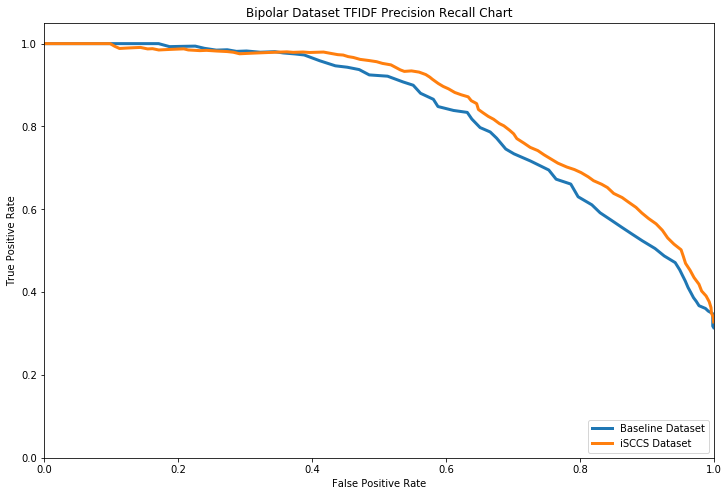

In [272]:
names = ["Baseline Dataset", "iSCCS Dataset"]

SCORES = [reduce(reduce_fun, [time_list[1][1] for time_list in Score_Label_results]),
          reduce(reduce_fun, [time_list[-1][1] for time_list in Score_Label_results])]

LABELS = [reduce(reduce_fun, [time_list[1][0] for time_list in Score_Label_results]),
          reduce(reduce_fun, [time_list[-1][0] for time_list in Score_Label_results])]

renderPRC(SCORES, LABELS, "Bipolar Dataset TFIDF",names)  

Average Precision
	Base_Pol        : 0.391855751797
	Base_TFIDF      : 0.829718702632
	tPol            : 0.874148645044
	tLate Pol       : 0.885800548243
	tLong Pol       : 0.897543618631
	tLIWC           : 0.757972606279
	tTFIDF          : 0.854571523254


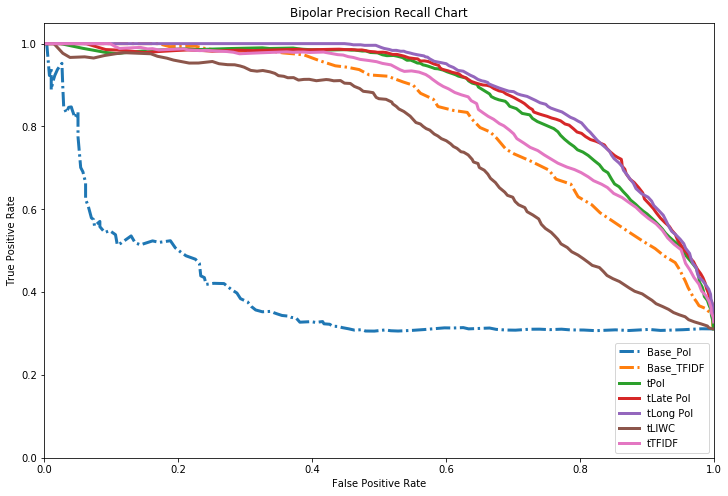

In [274]:
names = ["Base_Pol", "Base_TFIDF", "tPol", "tLate Pol", "tLong Pol", "tLIWC", "tTFIDF"]

SCORES = [reduce(reduce_fun, [time_list[i][1] for time_list in Score_Label_results]) for i in xrange(len(names))]
LABELS = [reduce(reduce_fun, [time_list[i][0] for time_list in Score_Label_results]) for i in xrange(len(names))]

renderPRC(SCORES, LABELS, "Bipolar",names, linestyle=['dashdot','dashdot','solid','solid','solid','solid','solid']) 

In [ ]:
def plotPRC(scores, labels, disorder ,names,
              linestyle=['solid','solid','solid','solid','dashdot','dashdot','dashdot','dashdot'],
              colors = None,
              linewidth = 3,
              transparent = 1):
    
    fig, ax = plt.subplots()
    print("Average Precision")
    for i,(score, label) in enumerate(zip(scores, labels)):        
        precision, recall, _ = precision_recall_curve(label, score, pos_label=1)
        average_precision = average_precision_score(label, score)
        
        if colors:
            plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=linewidth, color=colors[i], alpha=transparent)
        else:
            plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=linewidth, alpha=transparent)
            
        print("\t{:15} : {}".format(names[i],average_precision))

   

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Precision Recall Chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()

## Evaluation

In [ ]:
bipolar_index = [i for i, value in enumerate(bipolar_LABELS[0]) if value == 1]

bipolar_value = [bipolar_SCORES[0][i] for i in bipolar_index]

regular_value = [bipolar_SCORES[0][i] for i in range(len(bipolar_SCORES[0])) if i not in bipolar_index]

plt.hist(bipolar_value, label = 'Bipolar', alpha=0.6)
plt.hist(regular_value, label = 'Regular', alpha=0.6)

plt.grid(True)
plt.xlabel("Probability")
plt.ylabel("Frequency")

plt.ylim([0, 550])
plt.legend() 
plt.show() 
plt.close()

In [ ]:
b_P_list = []
b_R_list = []
r_p_list = []
r_R_list = []
thre_list = np.arange(0.4,0.91,0.001)
for thre in thre_list:

    bipolar_index = [i for i, value in enumerate(bipolar_LABELS[0]) if value == 1]

    bipolar_value = [bipolar_SCORES[0][i] for i in bipolar_index]

    TP_bipolar_value = filter(lambda x: x >= thre, bipolar_value)

    regular_value = [bipolar_SCORES[0][i]for i in range(len(bipolar_SCORES[0])) if i not in bipolar_index]

    TN_regular_value = filter(lambda x: x < thre, regular_value)

    Total_Bipolar = len(bipolar_value)

    Total_Regular = len(regular_value)

    FP = Total_Regular - len(TN_regular_value)

    FN = Total_Bipolar - len(TP_bipolar_value)

    b_P = float(len(TP_bipolar_value))/(len(TP_bipolar_value) + FP)
    b_R = float(len(TP_bipolar_value))/len(bipolar_value)
    r_p = float(len(TN_regular_value))/(len(TN_regular_value) + FN)
    r_R = float(len(TN_regular_value))/len(regular_value)

    b_P_list.append(b_P)
    b_R_list.append(b_R)
    r_p_list.append(r_p)
    r_R_list.append(r_R)


In [ ]:
plt.plot(thre_list, b_P_list, 'r', label='Bipolar Precision')
plt.plot(thre_list, b_R_list, 'b', label='Bipolar Recall')
plt.legend()
plt.show() 
plt.close()

In [ ]:
plt.plot(thre_list, r_p_list, 'g', label='Regular Precision')
plt.plot(thre_list, r_R_list, 'm', label='Regular Recall')
plt.legend()
plt.show() 
plt.close()

In [ ]:
plt.plot(thre_list, r_p_list, 'g', label='Regular Precision')
plt.plot(thre_list, r_R_list, 'm', label='Regular Recall')
plt.plot(thre_list, b_P_list, 'r', label='Bipolar Precision')
plt.plot(thre_list, b_R_list, 'b', label='Bipolar Recall')
plt.legend()
plt.show() 
plt.close()

In [ ]:
for i, value in enumerate(thre_list):
    if b_P_list[i] < r_R_list[i]:
        cross_i = i
        upper_bound = thre_list[i]
        print upper_bound
        break
for i, value in enumerate(thre_list):
    if r_p_list[i] < b_P_list[i]:
        
        lower_bound = thre_list[i]
        print lower_bound
        break

In [ ]:
print('Bipolar Precision: {}'.format(b_P_list[cross_i]))
print('Bipolar Recall: {}'.format(b_R_list[cross_i]))
plt.hist(bipolar_value)
plt.grid(True)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Bipolar")
plt.ylim([0, 550])
# plt.xlim([0.4, 0.9])
plt.show()
plt.close()

print('Regular Precision: {}'.format(r_p_list[cross_i]))
print('Regular Recall: {}'.format(r_R_list[cross_i]))
plt.hist(regular_value)
plt.grid(True)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Regular")
plt.ylim([0, 550])
# plt.xlim([0.4, 0.9])
plt.show() 
plt.close()

In [ ]:
# Cut in different value

bipolar_index = [i for i, value in enumerate(bipolar_LABELS[0]) if value == 1]

bipolar_value = [bipolar_SCORES[0][i] for i in bipolar_index]

TP_bipolar_value = filter(lambda x: x >= upper_bound, bipolar_value)

regular_value = [bipolar_SCORES[0][i] for i in range(len(bipolar_SCORES[0])) if i not in bipolar_index]

TN_regular_value = filter(lambda x: x < lower_bound, regular_value)

FP = len(filter(lambda x: x < lower_bound, bipolar_value))

FN = len(filter(lambda x: x >= upper_bound, regular_value))

b_P = float(len(TP_bipolar_value))/(len(TP_bipolar_value) + FP)
b_R = float(len(TP_bipolar_value))/(len(TP_bipolar_value)+FN )
r_p = float(len(TN_regular_value))/(len(TN_regular_value) + FN)
r_R = float(len(TN_regular_value))/(len(TN_regular_value)+ FP)

print('Bipolar Precision: {}'.format(b_P))
print('Bipolar Recall: {}'.format(b_R))
print 
print('Regular Precision: {}'.format(r_p))
print('Regular Recall: {}'.format(r_R))

plt.hist(filter(lambda x: x >= upper_bound or x < lower_bound, bipolar_value), label = 'Bipolar', alpha=0.6)
plt.hist(filter(lambda x: x >= upper_bound or x < lower_bound, regular_value), label = 'Regular', alpha=0.6)

plt.grid(True)
plt.xlabel("Probability")
plt.ylabel("Frequency")

plt.ylim([0, 550])
plt.legend() 
plt.show() 
plt.close()

# Check Polarity user

In [ ]:
from collections import Counter

In [ ]:
under_lower_index = [i for i in bipolar_index if bipolar_SCORES[0][i] < lower_bound]
under_lower_user = [(pol_groups.getGroupUserName()[int(bipolar_NAMES[0][i])], bipolar_SCORES[0][i]) for i in under_lower_index]
# Counter([name for name, value in under_lower_user]).most_common()


## BD user Predict < 0.3

In [ ]:
Counter([name for name, value in filter(lambda x: x[1]<0.3 ,under_lower_user)]).most_common()

## Regular user Predict > 0.7

In [ ]:
regular_index = [i for i in xrange(len(bipolar_SCORES[0])) if i not in bipolar_index]
on_upper_index = [i for i in regular_index if bipolar_SCORES[0][i] > upper_bound]
on_upper_user = [(pol_groups.getBaseUserName()[int(bipolar_NAMES[0][i])], bipolar_SCORES[0][i]) for i in regular_index]
# Counter([name for name, value in on_upper_user]).most_common()


In [ ]:
Counter([name for name, value in filter(lambda x: x[1]>0.7 ,on_upper_user)]).most_common()

In [ ]:
# for i, user in enumerate(regular_clean):
#     if user['name'][0] != 118151476:continue
#     print i

In [ ]:
# regular_clean[152]

## Testing Predict Model

In [ ]:
def getPOLFeature(timeSeries):
#     features = np.zeros((len(user_timeSeries_list),20),dtype=float)
    features = np.zeros((20),dtype=float)
        
    tweets_length = float(timeSeries.shape[0])
    tweets_rate = getTweetRate(timeSeries)
    late_tweets_rate = getLateTweetRate(timeSeries)
    mention_rate = getMentionRate(timeSeries)
    unique_mentions = getUniqueMentions(timeSeries)
    frequent_mentions = getFrequentMentions(timeSeries)
    negative_ratio = getNegativeRatio(timeSeries)
    positive_ratio = getPositiveRatio(timeSeries)
    flips_ratio = getFlipsCount(timeSeries) / tweets_length
    negative_combos = getCombosCount(timeSeries,matcher=-1) / tweets_length
    positive_combos = getCombosCount(timeSeries,matcher=1) / tweets_length
    emotion_counts_dict = getUsersEmotions(timeSeries)


    age = getAge(timeSeries)
    gender = getGender(timeSeries)

    features[0] = tweets_rate
    features[1] = late_tweets_rate
    features[2] = mention_rate
    features[3] = unique_mentions
    features[4] = frequent_mentions 
    features[5] = positive_ratio
    features[6] = negative_ratio
    features[7] = flips_ratio
    features[8] = negative_combos
    features[9] = positive_combos
    features[10] = age
    features[11] = gender
    for j, emotion in enumerate(["joy","sadness","fear", "anticipation", "anger", "trust", "disgust" ,"surprise"]):
        features[12+j] = np.mean(emotion_counts_dict[emotion])
        
            
    return features

In [ ]:
# #Dump the pre-trained models

# # Get feature
feature_order = ['tweets_rate', 'late_tweets_rate','mention_rate','unique_mentions','frequent_mentions','positive_ratio',\
                 'negative_ratio','flips','negative_combos','positive_combos', 'age', 'gender', "joy","sadness","fear",  \
                 "anticipation", "anger", "trust", "disgust" ,"surprise", "long_tweets_rate"]
online_selection = []

for feature_name in feature_order:
    for i,(name, category) in enumerate(pol_groups.index2feature):
        if name == feature_name:
            online_selection.append(i)
print(online_selection)
            
classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)

X, Y = pol_groups.getLabeledData("Bipolar", selection=online_selection)

sss = StratifiedShuffleSplit(Y[:,0], n_fold, test_size = 0.4, random_state=randint(0,65536) )

for train_index, test_index in sss:
    X_train, X_test           = X[train_index], X[test_index]
    Y_train, Y_test           = Y[train_index][:,0], Y[test_index][:,0]
    Y_train_name, Y_test_name = Y[train_index][:,1], Y[test_index][:,1]

    classifier.fit(X_train, Y_train)

SCORES = [classifier.predict_proba(X_test)[:,1]]
LABELS = [Y[test_index][:,0]]

In [ ]:
renderPRC(SCORES, LABELS, "Bipolar", ["Pattern of Life"])

In [ ]:
#joblib.dump(classifier,"models/bipolar_forest/bipolar_forest_long_term")

## Check the Feature Order

In [ ]:
for cursor, (name,category) in enumerate(pol_groups.getIndex2Feature()):
    print '{}\t{}\t{}'.format(cursor, name, category)

## Check Testing Result

In [ ]:
bd_testing_list = []
for i, lab in enumerate(LABELS):
    if lab[0] == 1:
        bd_testing_list.append(SCORES[i])
plt.plot(sorted(bd_testing_list))
plt.show()
plt.close()    

## Check Training Result

In [ ]:
bd_testing_list = []
train_score = classifier.predict_proba(X_train)[0][:,1]
for i, lab in enumerate(Y[train_index]):
    if lab[0] == 1:
        bd_testing_list.append(train_score[i])
plt.plot(sorted(bd_testing_list))
plt.show()
plt.close()   

## Check Original BD user Dataset

In [ ]:
# proba_list = []
# for timeSeries in bd_clean:
#     bd_features = getPOLFeature(timeSeries)
#     bd_proba = classifier.predict_proba(bd_features)[0][1]
#     proba_list.append(bd_proba)
    
# plt.plot(sorted(proba_list))
# plt.show()
# plt.close()
